In [23]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import set_config
set_config(display="diagram")

import lib.taa_tools as taa

np.set_printoptions(threshold=10000,suppress=True) 
filterwarnings('ignore')

CREDIT_SCORE = "../data/credit_scoring.csv"
CREDIT_SCORE_HET = "../data/credit.data"
SPAM = "../data/SMSSpamCollection.data"
YELP = "../data/yelp-text-by-stars.csv"

# I) Apprentissage supervisé : Feature engineering et Classification

## Chargement des données et préparation :

In [24]:
df_credit = pd.read_csv(CREDIT_SCORE, sep=";")

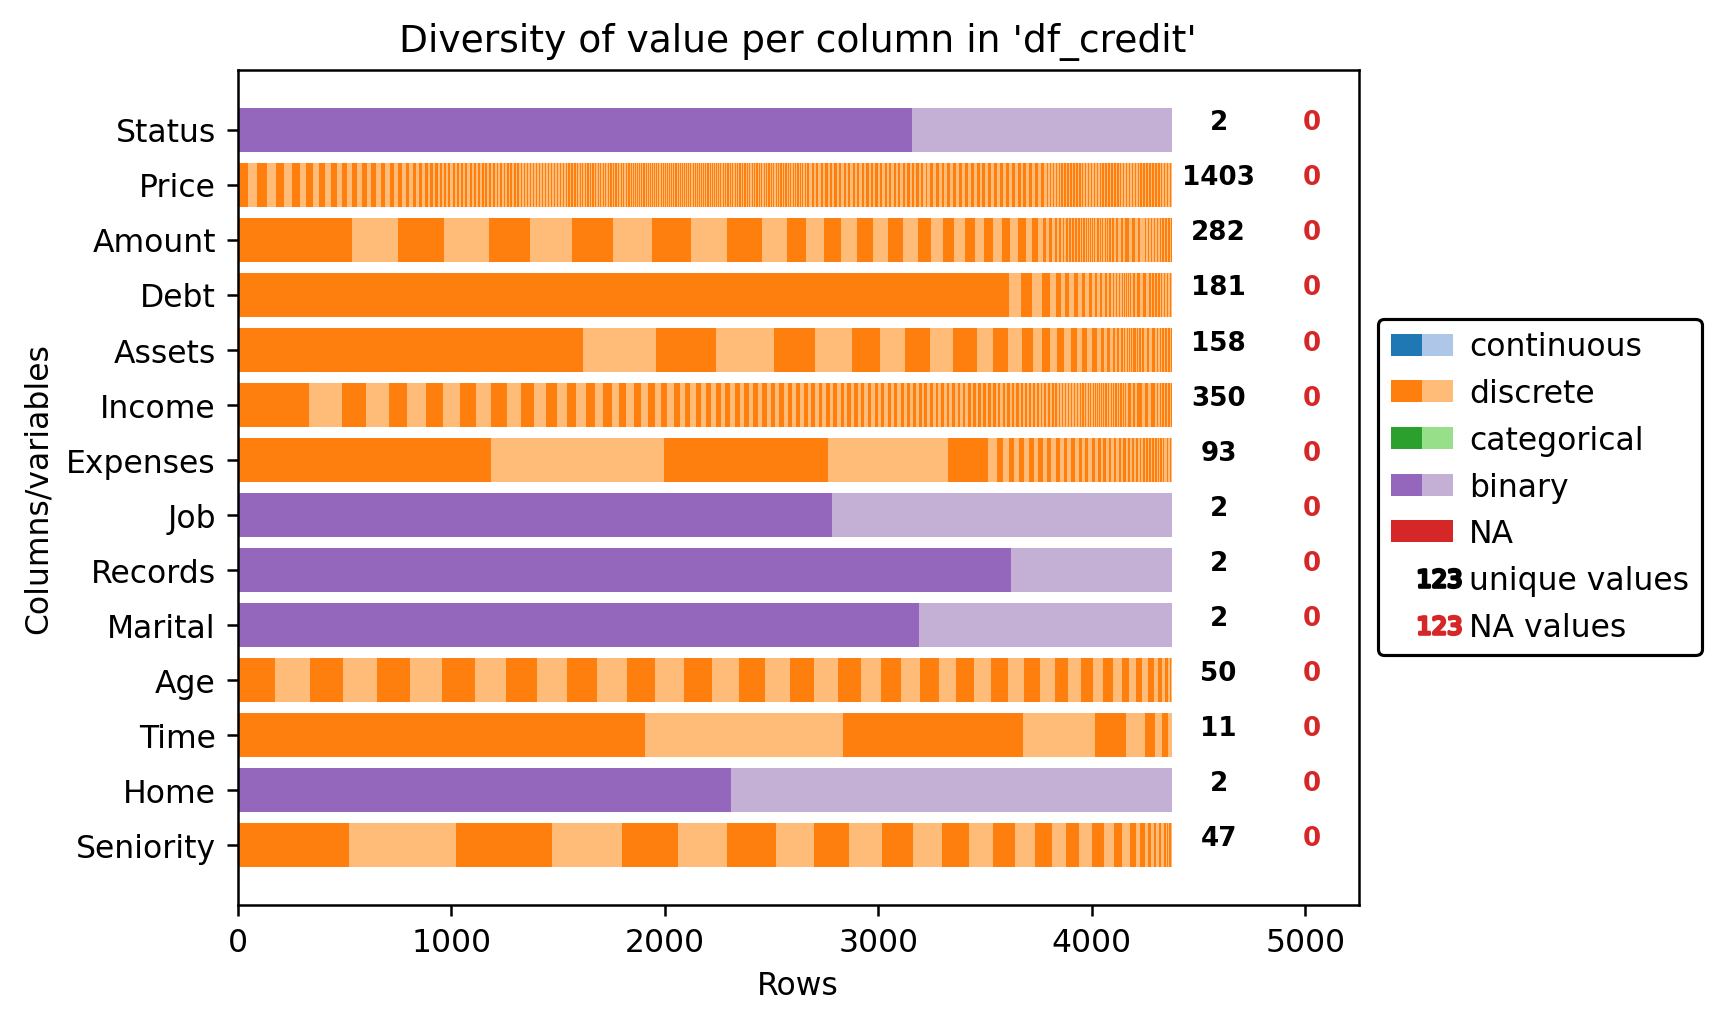

In [25]:
taa.explore_data(df_credit, "df_credit")

Le jeu de donnée 'credit_scoring.csv' présente 14 colonnes/variables et 4375 lignes/enregistrements. Chaque enregistrement est une demande de crédit, pour chaque demandeur est renseigné 13 variables d'entrée et 1 variable de sortie. Toutes les variables sont de natures numériques (certaines sont binaires). 
La colonne 'Status' est la variable de sortie que l'on va essayer de prédire à parir de ces variables d'entrée. Son codage correspond à:
- 1: Solvable
- 0: Non-solvable

In [26]:
from sklearn.model_selection import train_test_split


X, Y = df_credit.values[:, :-1], df_credit.values[:, -1]
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.5, random_state=1)

## Apprentissage et évaluation de modèles :

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

COLS_EVAL = ["method", "comment", "precision", "accuracy", "recall", "VP", "VN", "FP", "FN", "args"]
DATAS=(xtrain, ytrain, xtest, ytest)

# tests
cart_test = taa.test_model(*DATAS, DecisionTreeClassifier, random_state=1)
knn_test = taa.test_model(*DATAS, KNeighborsClassifier, n_neighbors=5)
mlp_test = taa.test_model(*DATAS, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1)

df_comparative = pd.concat([cart_test, knn_test, mlp_test], ignore_index=True).drop_duplicates()

Results for DecisionTreeClassifier  {'random_state': 1}
        accuracy       precision          recall
           0.727           0.819           0.799
Confusion matrix:


,predicted 0,predicted 1
is 0,325,279
is 1,318,1266


Results for KNeighborsClassifier  {'n_neighbors': 5}
        accuracy       precision          recall
           0.725           0.771           0.882
Confusion matrix:


,predicted 0,predicted 1
is 0,189,415
is 1,187,1397


Results for MLPClassifier  {'hidden_layer_sizes': (40, 20), 'random_state': 1}
        accuracy       precision          recall
           0.737           0.795           0.857
Confusion matrix:


,predicted 0,predicted 1
is 0,255,349
is 1,227,1357


On définit la **precision** (ou **positive predictive value**): $\frac{VP}{VP+FP}$ "Parmis les prédictions positives, lesquelles sont justes/vraies"

On définit l'**accuracy** : $\frac{VP+FN}{VP+FP+VN+FN}$ "Parmis l'ensemble des prédictions, lesquelles sont justes"

On définit le **recall** (ou **sensibilité** ou **true positive rate**): $\frac{VP}{VP+FN}$ "Parmis les cas postifs, lesquelles sont prédites"

Dans notre situation, nous représentons l'assureur, nous voulons éviter les impayés ! il faut alors minimiser au possible les **faux positifs** (c'est à dire ne pas attribuer un prêt alors qu'un agent ne l'aurait pas fait). 
Ainsi le critère de **précision** est plus important que le recall puisque son calcul prend en compte les faux positifs (la précision augment à mesure que les FP diminue).

Dans ce premier test, c'est la méthode par arbre de décision qui a la plus basse precision (0.82 c'est le plus prudent) mais au prix d'une nombre plus faible de call positif (et par conséquent moins de client).
Bien que toutes les méthodes ont une accuracy quasi-similaire, leurs décisions sont très différentes à en regarder les matrices de confusion associée.

## Normalisation des variables continues :

In [28]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Standard scaling datas
stdScale=StandardScaler()
stdScale.fit(xtrain)
xtrain_ss, xtest_ss = stdScale.transform(xtrain), stdScale.transform(xtest)

# Min max scaling datas
mmScale= MinMaxScaler()
mmScale.fit(xtrain)
xtrain_mm, xtest_mm = mmScale.transform(xtrain), mmScale.transform(xtest)

DATAS_SS = (xtrain_ss, ytrain, xtest_ss, ytest)
DATAS_MM = (xtrain_mm, ytrain, xtest_mm, ytest)

# test
cart_test_ss = taa.test_model(*DATAS_SS, DecisionTreeClassifier, random_state=1, comment="StdScale")
cart_test_mm = taa.test_model(*DATAS_MM, DecisionTreeClassifier, random_state=1, comment="MinMaxScale")
knn_test_ss = taa.test_model(*DATAS_SS, KNeighborsClassifier, n_neighbors=5, comment="StdScale")
knn_test_mm = taa.test_model(*DATAS_MM, KNeighborsClassifier, n_neighbors=5, comment="MinMaxScale")
mlp_test_ss = taa.test_model(*DATAS_SS, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="StdScale")
mlp_test_mm = taa.test_model(*DATAS_MM, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="MinMaxScale")

df_comparative = pd.concat([df_comparative, 
        cart_test_ss, knn_test_ss, mlp_test_ss,
        cart_test_mm, knn_test_mm, mlp_test_mm
        ], ignore_index=True).drop_duplicates()

Results for DecisionTreeClassifier StdScale {'random_state': 1}
        accuracy       precision          recall
           0.727           0.818           0.801
Confusion matrix:


,predicted 0,predicted 1
is 0,322,282
is 1,315,1269


Results for DecisionTreeClassifier MinMaxScale {'random_state': 1}
        accuracy       precision          recall
           0.729           0.820           0.801
Confusion matrix:


,predicted 0,predicted 1
is 0,325,279
is 1,315,1269


Results for KNeighborsClassifier StdScale {'n_neighbors': 5}
        accuracy       precision          recall
           0.753           0.811           0.859
Confusion matrix:


,predicted 0,predicted 1
is 0,286,318
is 1,223,1361


Results for KNeighborsClassifier MinMaxScale {'n_neighbors': 5}
        accuracy       precision          recall
           0.745           0.808           0.851
Confusion matrix:


,predicted 0,predicted 1
is 0,283,321
is 1,236,1348


Results for MLPClassifier StdScale {'hidden_layer_sizes': (40, 20), 'random_state': 1}
        accuracy       precision          recall
           0.777           0.838           0.857
Confusion matrix:


,predicted 0,predicted 1
is 0,342,262
is 1,227,1357


Results for MLPClassifier MinMaxScale {'hidden_layer_sizes': (40, 20), 'random_state': 1}
        accuracy       precision          recall
           0.789           0.832           0.887
Confusion matrix:


,predicted 0,predicted 1
is 0,321,283
is 1,179,1405


## Création de nouvelles variables caractéristiques par combinaisons linéaires des variables initiales :

In [29]:
from sklearn.decomposition import PCA

# PCA computation
pca = PCA()
pca.fit(xtrain_ss)
pca_train, pca_test = pca.transform(xtrain_ss), pca.transform(xtest_ss)

# bind the 3 first PCA axis to std scalled x datas
xtrain_ss_pca = np.column_stack((xtrain_ss, pca_train[:, :3]))
xtest_ss_pca = np.column_stack((xtest_ss, pca_test[:, :3]))

DATAS_SS_PCA = (xtrain_ss_pca, ytrain, xtest_ss_pca, ytest)

# test
cart_test_ss_pca = taa.test_model(*DATAS_SS_PCA, DecisionTreeClassifier, random_state=1, comment="StdScale + PCA")
knn_test_ss_pca = taa.test_model(*DATAS_SS_PCA, KNeighborsClassifier, n_neighbors=5, comment="StdScale + PCA")
mlp_test_ss_pca = taa.test_model(*DATAS_SS_PCA, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="StdScale + PCA")

df_comparative = pd.concat([df_comparative, cart_test_ss_pca, knn_test_ss_pca, mlp_test_ss_pca], ignore_index=True).drop_duplicates()

Results for DecisionTreeClassifier StdScale + PCA {'random_state': 1}
        accuracy       precision          recall
           0.736           0.833           0.795
Confusion matrix:


,predicted 0,predicted 1
is 0,351,253
is 1,324,1260


Results for KNeighborsClassifier StdScale + PCA {'n_neighbors': 5}
        accuracy       precision          recall
           0.756           0.810           0.866
Confusion matrix:


,predicted 0,predicted 1
is 0,283,321
is 1,212,1372


Results for MLPClassifier StdScale + PCA {'hidden_layer_sizes': (40, 20), 'random_state': 1}
        accuracy       precision          recall
           0.770           0.827           0.863
Confusion matrix:


,predicted 0,predicted 1
is 0,318,286
is 1,217,1367


## Sélection de variables :

['Income' 'Seniority' 'Price' 'Amount' 'Age' 'Assets' 'Expenses' 'Records'
 'Time' 'Job' 'Debt' 'Home' 'Marital']


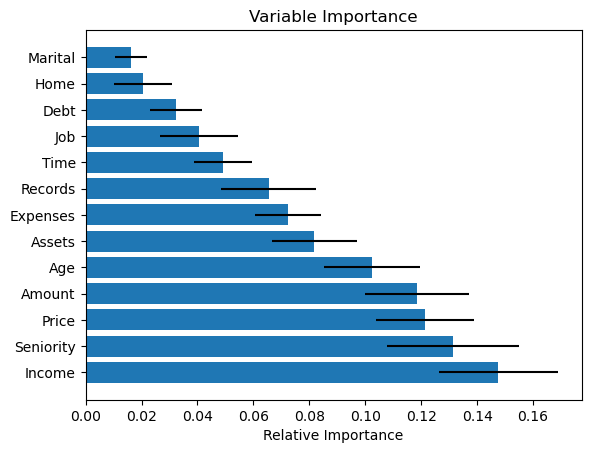

In [30]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state = 1)
clf.fit(xtrain_ss, ytrain)
importances=clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
sorted_idx = np.argsort(importances)[::-1]
features = df_credit.columns.values
print(features[sorted_idx])
padding = np.arange(xtrain_ss.size/len(xtrain_ss)) + 0.5 
plt.barh(padding, importances[sorted_idx],xerr=std[sorted_idx], align='center') 
plt.yticks(padding, features[sorted_idx]) 
plt.xlabel("Relative Importance")
plt.title("Variable Importance") 
plt.show()

test_trimming: Loaded from ../res/__cache_pickle__/test_trimming/fc2a8a767dd744c6aad026a9afa8d1cd0daf727e.pkl


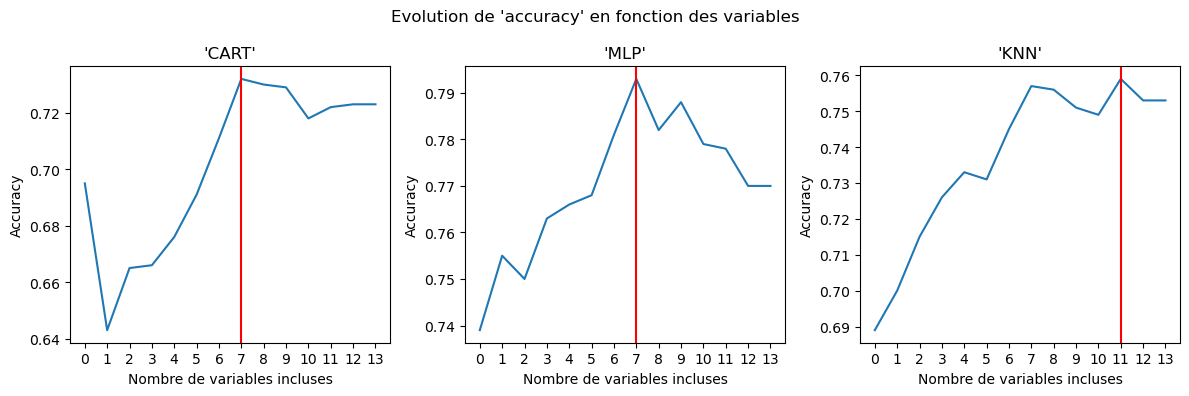

In [31]:
MODELS = {
    "CART": DecisionTreeClassifier(random_state=1),
    "MLP" : MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1),
    "KNN" : KNeighborsClassifier(n_neighbors=5)
}

trim_test = taa.test_trimming(*DATAS_SS, MODELS, sorted_idx)

taa.results_test_trimming(trim_test)

In [32]:
# trimming
SIGNIFICANCE_COLS = sorted_idx[:8]
X_trimmed = X[:, SIGNIFICANCE_COLS]

xtrain_trim, xtest_trim, ytrain, ytest = train_test_split(X_trimmed, Y, test_size=0.5, random_state=1)

# Stdscale
stdScale=StandardScaler()
stdScale.fit(xtrain_trim)

#Trim + stdScale
xtrain_trim_ss = stdScale.transform(xtrain_trim)
xtest_trim_ss = stdScale.transform(xtest_trim)

#Trim + stdScale + PCA
xtrain_trim_ss_pca = np.column_stack((xtrain_trim_ss, pca_train[:, :3]))
xtest_trim_ss_pca = np.column_stack((xtest_trim_ss, pca_test[:, :3]))


DATAS_TRIM_SS_PCA = (xtrain_trim_ss_pca, ytrain, xtest_trim_ss_pca, ytest)
DATAS_TRIM_SS = (xtrain_trim_ss, ytrain, xtest_trim_ss, ytest)

# test Trim + stdScale
cart_test_trim_ss = taa.test_model(*DATAS_TRIM_SS, DecisionTreeClassifier, random_state=1, comment="Trim + StdScale")
knn_test_trim_ss = taa.test_model(*DATAS_TRIM_SS, KNeighborsClassifier, n_neighbors=5, comment="Trim + StdScale")
mlp_test_trim_ss = taa.test_model(*DATAS_TRIM_SS, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="Trim + StdScale")

# test Trim + stdScale + PCA
cart_test_trim_ss_pca = taa.test_model(*DATAS_TRIM_SS_PCA, DecisionTreeClassifier, random_state=1, comment="Trim + StdScale + PCA")
knn_test_trim_ss_pca = taa.test_model(*DATAS_TRIM_SS_PCA, KNeighborsClassifier, n_neighbors=5, comment="Trim + StdScale + PCA")
mlp_test_trim_ss_pca = taa.test_model(*DATAS_TRIM_SS_PCA, MLPClassifier, hidden_layer_sizes=(40, 20), random_state=1, comment="Trim + StdScale + PCA")


df_comparative = pd.concat([df_comparative, 
        cart_test_trim_ss, knn_test_trim_ss, mlp_test_trim_ss,
        cart_test_trim_ss_pca, knn_test_trim_ss_pca, mlp_test_trim_ss_pca
        ], ignore_index=True).drop_duplicates()

Results for DecisionTreeClassifier Trim + StdScale {'random_state': 1}
        accuracy       precision          recall
           0.732           0.822           0.804
Confusion matrix:


,predicted 0,predicted 1
is 0,328,276
is 1,310,1274


Results for KNeighborsClassifier Trim + StdScale {'n_neighbors': 5}
        accuracy       precision          recall
           0.757           0.813           0.862
Confusion matrix:


,predicted 0,predicted 1
is 0,290,314
is 1,218,1366


Results for MLPClassifier Trim + StdScale {'hidden_layer_sizes': (40, 20), 'random_state': 1}
        accuracy       precision          recall
           0.793           0.841           0.881
Confusion matrix:


,predicted 0,predicted 1
is 0,340,264
is 1,189,1395


Results for DecisionTreeClassifier Trim + StdScale + PCA {'random_state': 1}
        accuracy       precision          recall
           0.714           0.817           0.779
Confusion matrix:


,predicted 0,predicted 1
is 0,328,276
is 1,350,1234


Results for KNeighborsClassifier Trim + StdScale + PCA {'n_neighbors': 5}
        accuracy       precision          recall
           0.761           0.811           0.873
Confusion matrix:


,predicted 0,predicted 1
is 0,281,323
is 1,201,1383


Results for MLPClassifier Trim + StdScale + PCA {'hidden_layer_sizes': (40, 20), 'random_state': 1}
        accuracy       precision          recall
           0.783           0.839           0.866
Confusion matrix:


,predicted 0,predicted 1
is 0,341,263
is 1,212,1372


In [33]:
df_comparative.sort_values(by="precision")

,method,comment,precision,accuracy,recall,VP,VN,FP,FN,args
1,KNeighborsClassifier,,0.770971,0.724863,0.881944,1397,189,415,187,{'n_neighbors': 5}
2,MLPClassifier,,0.795428,0.736746,0.856692,1357,255,349,227,"{'hidden_layer_sizes': (40, 20), 'random_state..."
7,KNeighborsClassifier,MinMaxScale,0.807669,0.745430,0.851010,1348,283,321,236,{'n_neighbors': 5}
10,KNeighborsClassifier,StdScale + PCA,0.810396,0.756399,0.866162,1372,283,321,212,{'n_neighbors': 5}
4,KNeighborsClassifier,StdScale,0.810602,0.752742,0.859217,1361,286,318,223,{'n_neighbors': 5}
16,KNeighborsClassifier,Trim + StdScale + PCA,0.810668,0.760512,0.873106,1383,281,323,201,{'n_neighbors': 5}
13,KNeighborsClassifier,Trim + StdScale,0.813095,0.756856,0.862374,1366,290,314,218,{'n_neighbors': 5}
15,DecisionTreeClassifier,Trim + StdScale + PCA,0.817219,0.713894,0.779040,1234,328,276,350,{'random_state': 1}
3,DecisionTreeClassifier,StdScale,0.818182,0.727148,0.801136,1269,322,282,315,{'random_state': 1}
0,DecisionTreeClassifier,,0.819417,0.727148,0.799242,1266,325,279,318,{'random_state': 1}


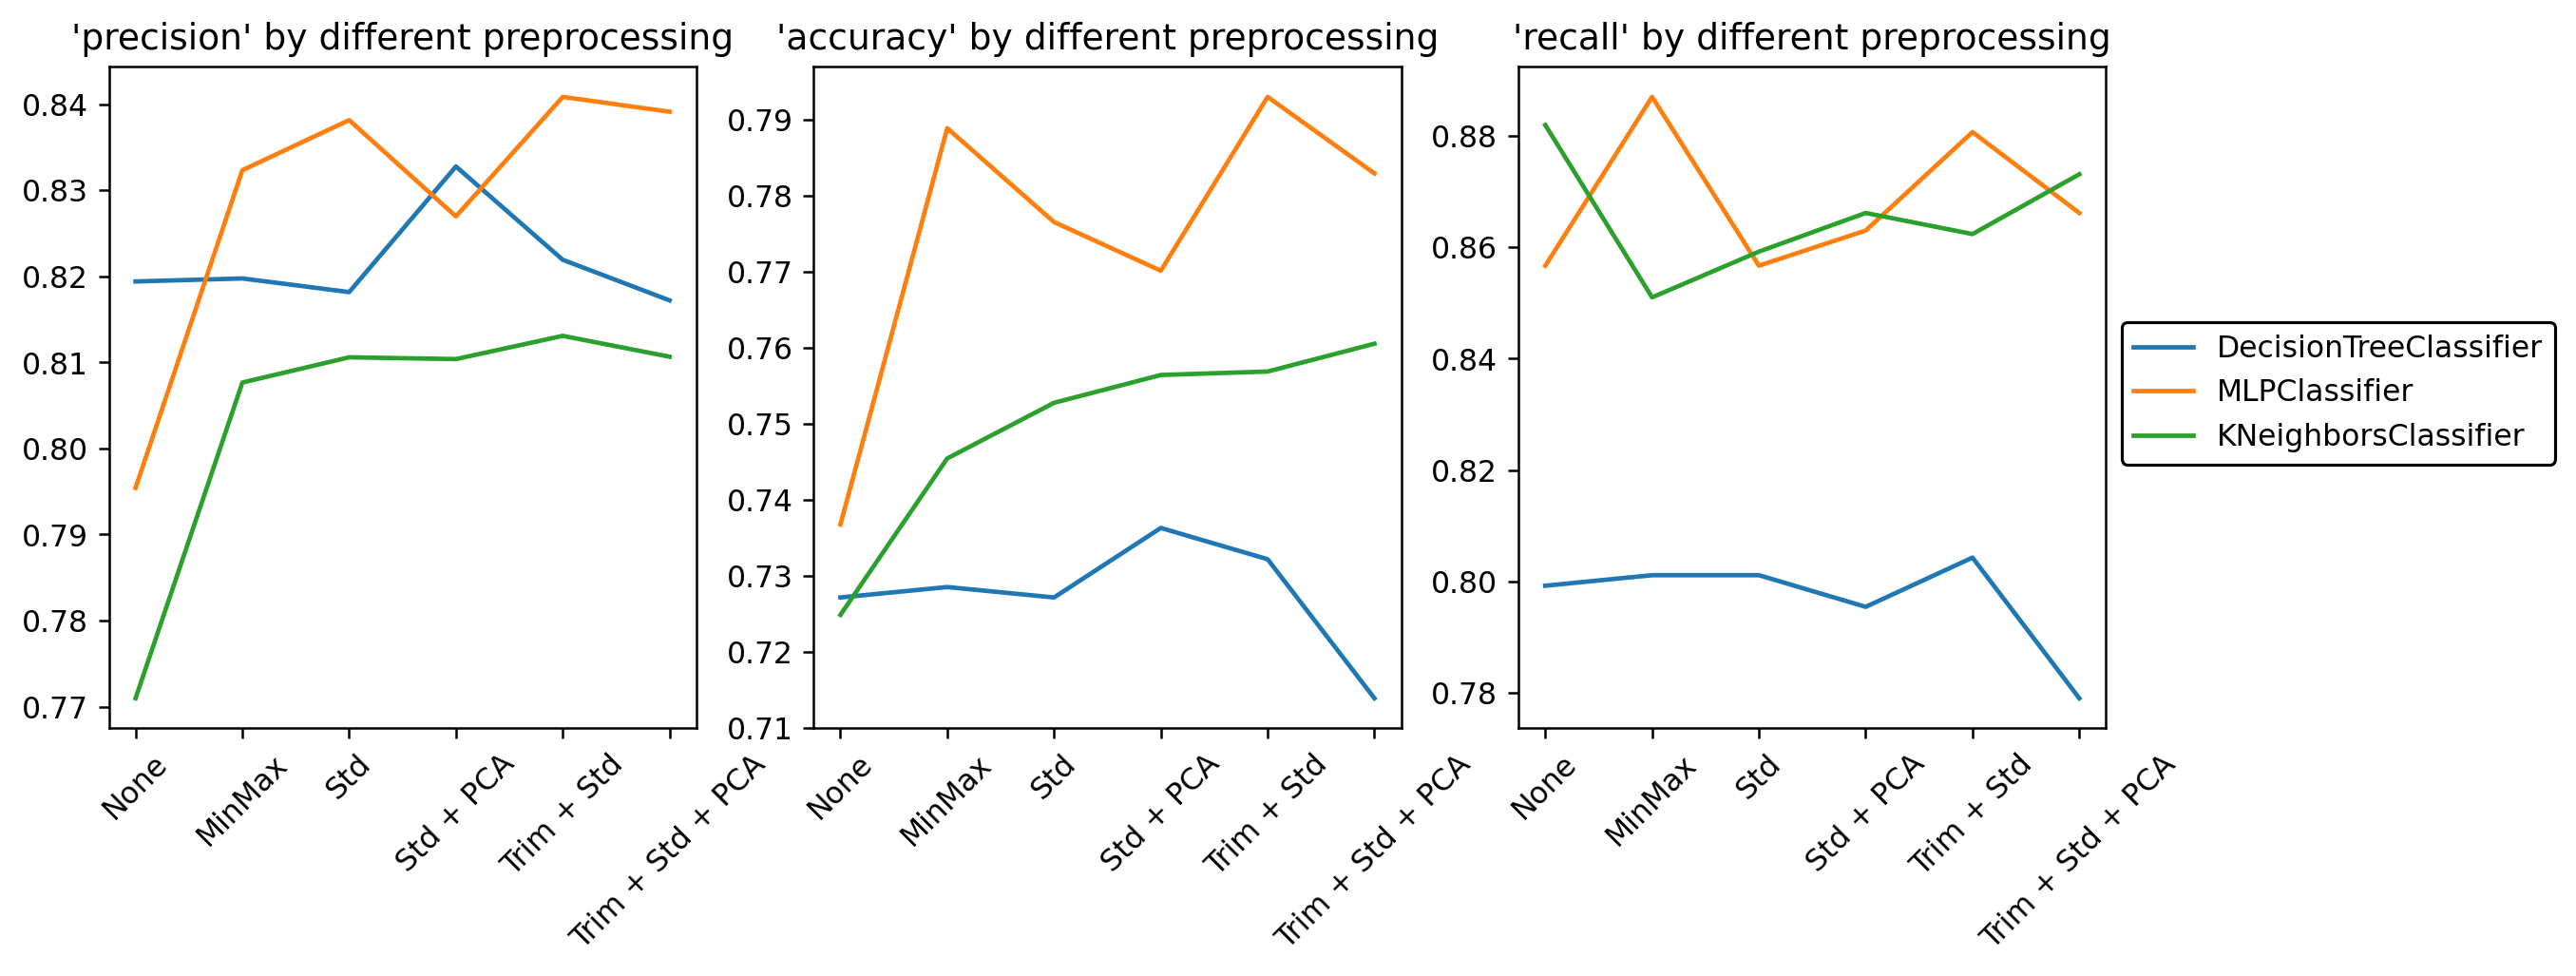

In [34]:
taa.comparative_preprocessing(df_comparative)

In [35]:
df_comparative.pivot_table(values=["precision", "accuracy"], index="comment", aggfunc="mean")

,accuracy,precision
comment,,
,0.729586,0.795272
MinMaxScale,0.754266,0.819928
StdScale,0.752133,0.822318
StdScale + PCA,0.754266,0.823387
Trim + StdScale,0.760664,0.825300
Trim + StdScale + PCA,0.752438,0.822344


## Paramétrage des classifieurs :

In [36]:
from sklearn.model_selection import GridSearchCV


@taa.cache_pickle  #to save the result inside ./res/__cache_pickle__
def find_best_param(sk_function, params, X_train, Y_train):
    gs = GridSearchCV(sk_function(), params, scoring="precision") #we target the best precision score)
    gs.fit(X_train, Y_train)
    return gs


parameters_knn = {
    "n_neighbors" : [i for i in range(1, 100, 5)],
    "weights" : ["uniform", "distance"],
    "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

parameters_cart = {
    "criterion" : ["gini", "entropy", "log_loss"],
    "splitter" : ["best", "random"],
    "max_depth" : [i for i in range(1, 25)]
}

parameters_mlp = {
    "activation" : ["identity", "logistic", "tanh", "relu"],
    "hidden_layer_sizes" : [(L1, L2) for L1 in range(15, 121, 15) for L2 in range(int(L1*0.2), int(L1*0.8)+1, int(L1/5))]
}

#grid search
gs_KNN = find_best_param(KNeighborsClassifier, parameters_knn, xtrain_trim_ss, ytrain)
gs_CART = find_best_param(DecisionTreeClassifier, parameters_cart, xtrain_ss_pca, ytrain)
gs_MLP = find_best_param(MLPClassifier, parameters_mlp, xtrain_trim_ss, ytrain)

print(gs_KNN.best_estimator_, "with precision:", gs_KNN.best_score_)
print(gs_CART.best_estimator_, "with precision:", gs_CART.best_score_)
print(gs_MLP.best_estimator_, "with precision:", gs_MLP.best_score_)

KNeighborsClassifier(n_neighbors=6) with precision: 0.810517460555068
DecisionTreeClassifier(criterion='entropy', max_depth=4) with precision: 0.8153575619529645
MLPClassifier(hidden_layer_sizes=(105, 42)) with precision: 0.8274896438214381


find_best_param: Loaded from ../res/__cache_pickle__/find_best_param/6aeed71825438416454318e0db788aec8e1f3041.pkl
find_best_param: Loaded from ../res/__cache_pickle__/find_best_param/31d03e3d1d8269cd0dbb918b5d364ce67ecec558.pkl
find_best_param: Loaded from ../res/__cache_pickle__/find_best_param/33f7200a8b1b3840f2026b6bc806c12c4b611f6e.pkl


## Création d'un pipeline :

In [37]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from pickle import load, dump


@taa.cache_pickle  #to save the result into ./res/__cache_pickle__
def fit_pipeline(pipeline, X_train, Y_train):
    pipeline.fit(X_train, Y_train)
    return pipeline

# CART preprocess
STD_PCA=FeatureUnion([
    ("stdScale", StandardScaler()),
    ("pca", PCA(n_components=3))
])

# CART
CART_PIPE=Pipeline([
    ("preprocess", STD_PCA),
    ("estimator", DecisionTreeClassifier(**gs_CART.best_params_))
])

# KNN and MLP preprocess
TRIM = ColumnTransformer([
    ("trim", "passthrough", SIGNIFICANCE_COLS)
])

TRIM_STD=Pipeline([
    ("trim", TRIM),
    ("stdScale", StandardScaler())
])

# MLP
MLP_PIPE=Pipeline([
    ("preprocess", TRIM_STD),
    ("estimator", MLPClassifier(**gs_MLP.best_params_))
])

# KNN
KNN_PIPE=Pipeline([
    ("preprocess", TRIM_STD),
    ("estimator", KNeighborsClassifier(**gs_KNN.best_params_))
])

# train pipelines
CART_PIPE = fit_pipeline(CART_PIPE, xtrain, ytrain)
MLP_PIPE = fit_pipeline(MLP_PIPE, xtrain, ytrain)
KNN_PIPE = fit_pipeline(KNN_PIPE, xtrain, ytrain)

# save it with pickle
dump(CART_PIPE, open("../res/pipe_cart.pkl", "wb"))
dump(MLP_PIPE, open("../res/pipe_mlp.pkl", "wb"))
dump(KNN_PIPE, open("../res/pipe_knn.pkl", "wb"))

del KNN_PIPE, CART_PIPE, MLP_PIPE

# load it with pickle
CART_PIPE = load(open("../res/pipe_cart.pkl", "rb"))
MLP_PIPE = load(open("../res/pipe_mlp.pkl", "rb"))
KNN_PIPE = load(open("../res/pipe_knn.pkl", "rb"))

display(CART_PIPE)
display(MLP_PIPE)
display(KNN_PIPE)

# test pipelines
test_pipe = taa.test_pipeline([CART_PIPE, MLP_PIPE, KNN_PIPE], xtest, ytest)
display(test_pipe)

fit_pipeline: Saved to ../res/__cache_pickle__/fit_pipeline/086e55b4d513f87091222eab651afca1a486aa16.pkl
fit_pipeline: Saved to ../res/__cache_pickle__/fit_pipeline/a1cb1000548a52a01e967a92d617231c1d71829b.pkl
fit_pipeline: Saved to ../res/__cache_pickle__/fit_pipeline/d5caf14a4b69e4488d5479f5e92e3fbbc5963570.pkl


Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('stdScale', StandardScaler()),
                                                ('pca', PCA(n_components=3))])),
                ('estimator',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4))])

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('trim',
                                  ColumnTransformer(transformers=[('trim',
                                                                   'passthrough',
                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                 ('stdScale', StandardScaler())])),
                ('estimator', MLPClassifier(hidden_layer_sizes=(105, 42)))])

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('trim',
                                  ColumnTransformer(transformers=[('trim',
                                                                   'passthrough',
                                                                   array([ 8,  0, 12, 11,  3,  9,  7,  5]))])),
                                 ('stdScale', StandardScaler())])),
                ('estimator', KNeighborsClassifier(n_neighbors=6))])

,method,accuracy,precision,recall,params
0,DecisionTreeClassifier,0.749543,0.832478,0.818813,"DecisionTreeClassifier(criterion='entropy', ma..."
1,MLPClassifier,0.769653,0.840479,0.841540,"MLPClassifier(hidden_layer_sizes=(105, 42))"
2,KNeighborsClassifier,0.744516,0.833008,0.809343,KNeighborsClassifier(n_neighbors=6)


## Comparaisons de plusieurs algorithmes d'apprentissages :

In [38]:
from IPython.display import Markdown

txt = "|**Key**|**Classifiers**|\n|--|--|\n"
for k, v in taa.CLASSIFIERS.items():
    txt += f"|{k}|{v}|\n"

Markdown(txt)

|**Key**|**Classifiers**|
|--|--|
|RF_10|RandomForestClassifier(n_estimators=10, random_state=1)|
|RF_20|RandomForestClassifier(n_estimators=20, random_state=1)|
|RF_40|RandomForestClassifier(n_estimators=40, random_state=1)|
|RF_80|RandomForestClassifier(n_estimators=80, random_state=1)|
|RF_120|RandomForestClassifier(n_estimators=120, random_state=1)|
|RF_160|RandomForestClassifier(n_estimators=160, random_state=1)|
|NB|GaussianNB()|
|QDA|QuadraticDiscriminantAnalysis()|
|MLP_20_10|MLPClassifier(hidden_layer_sizes=(20, 10), random_state=1)|
|MLP_40_20|MLPClassifier(hidden_layer_sizes=(40, 20), random_state=1)|
|MLP_60_30|MLPClassifier(hidden_layer_sizes=(60, 30), random_state=1)|
|MLP_100_50|MLPClassifier(hidden_layer_sizes=(100, 50), random_state=1)|
|CART_gini_5|DecisionTreeClassifier(max_depth=5, random_state=1)|
|CART_gini_10|DecisionTreeClassifier(max_depth=10, random_state=1)|
|CART_gini_15|DecisionTreeClassifier(max_depth=15, random_state=1)|
|CART_entropy_5|DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=1)|
|CART_entropy_10|DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=1)|
|CART_entropy_15|DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=1)|
|KNN_10|KNeighborsClassifier(n_neighbors=10)|
|KNN_20|KNeighborsClassifier(n_neighbors=20)|
|KNN_40|KNeighborsClassifier(n_neighbors=40)|
|KNN_80|KNeighborsClassifier(n_neighbors=80)|
|KNN_120|KNeighborsClassifier(n_neighbors=120)|
|KNN_160|KNeighborsClassifier(n_neighbors=160)|
|Bag_10|BaggingClassifier(random_state=1)|
|Bag_20|BaggingClassifier(n_estimators=20, random_state=1)|
|Bag_40|BaggingClassifier(n_estimators=40, random_state=1)|
|Bag_80|BaggingClassifier(n_estimators=80, random_state=1)|
|Bag_120|BaggingClassifier(n_estimators=120, random_state=1)|
|Bag_160|BaggingClassifier(n_estimators=160, random_state=1)|
|AdaB_20|AdaBoostClassifier(n_estimators=20, random_state=1)|
|AdaB_40|AdaBoostClassifier(n_estimators=40, random_state=1)|
|AdaB_80|AdaBoostClassifier(n_estimators=80, random_state=1)|
|AdaB_120|AdaBoostClassifier(n_estimators=120, random_state=1)|
|AdaB_160|AdaBoostClassifier(n_estimators=160, random_state=1)|


run_classifiers: Loaded from ../res/__cache_pickle__/run_classifiers/8d661f794e54a9cf629d811b270d5584335737c2.pkl


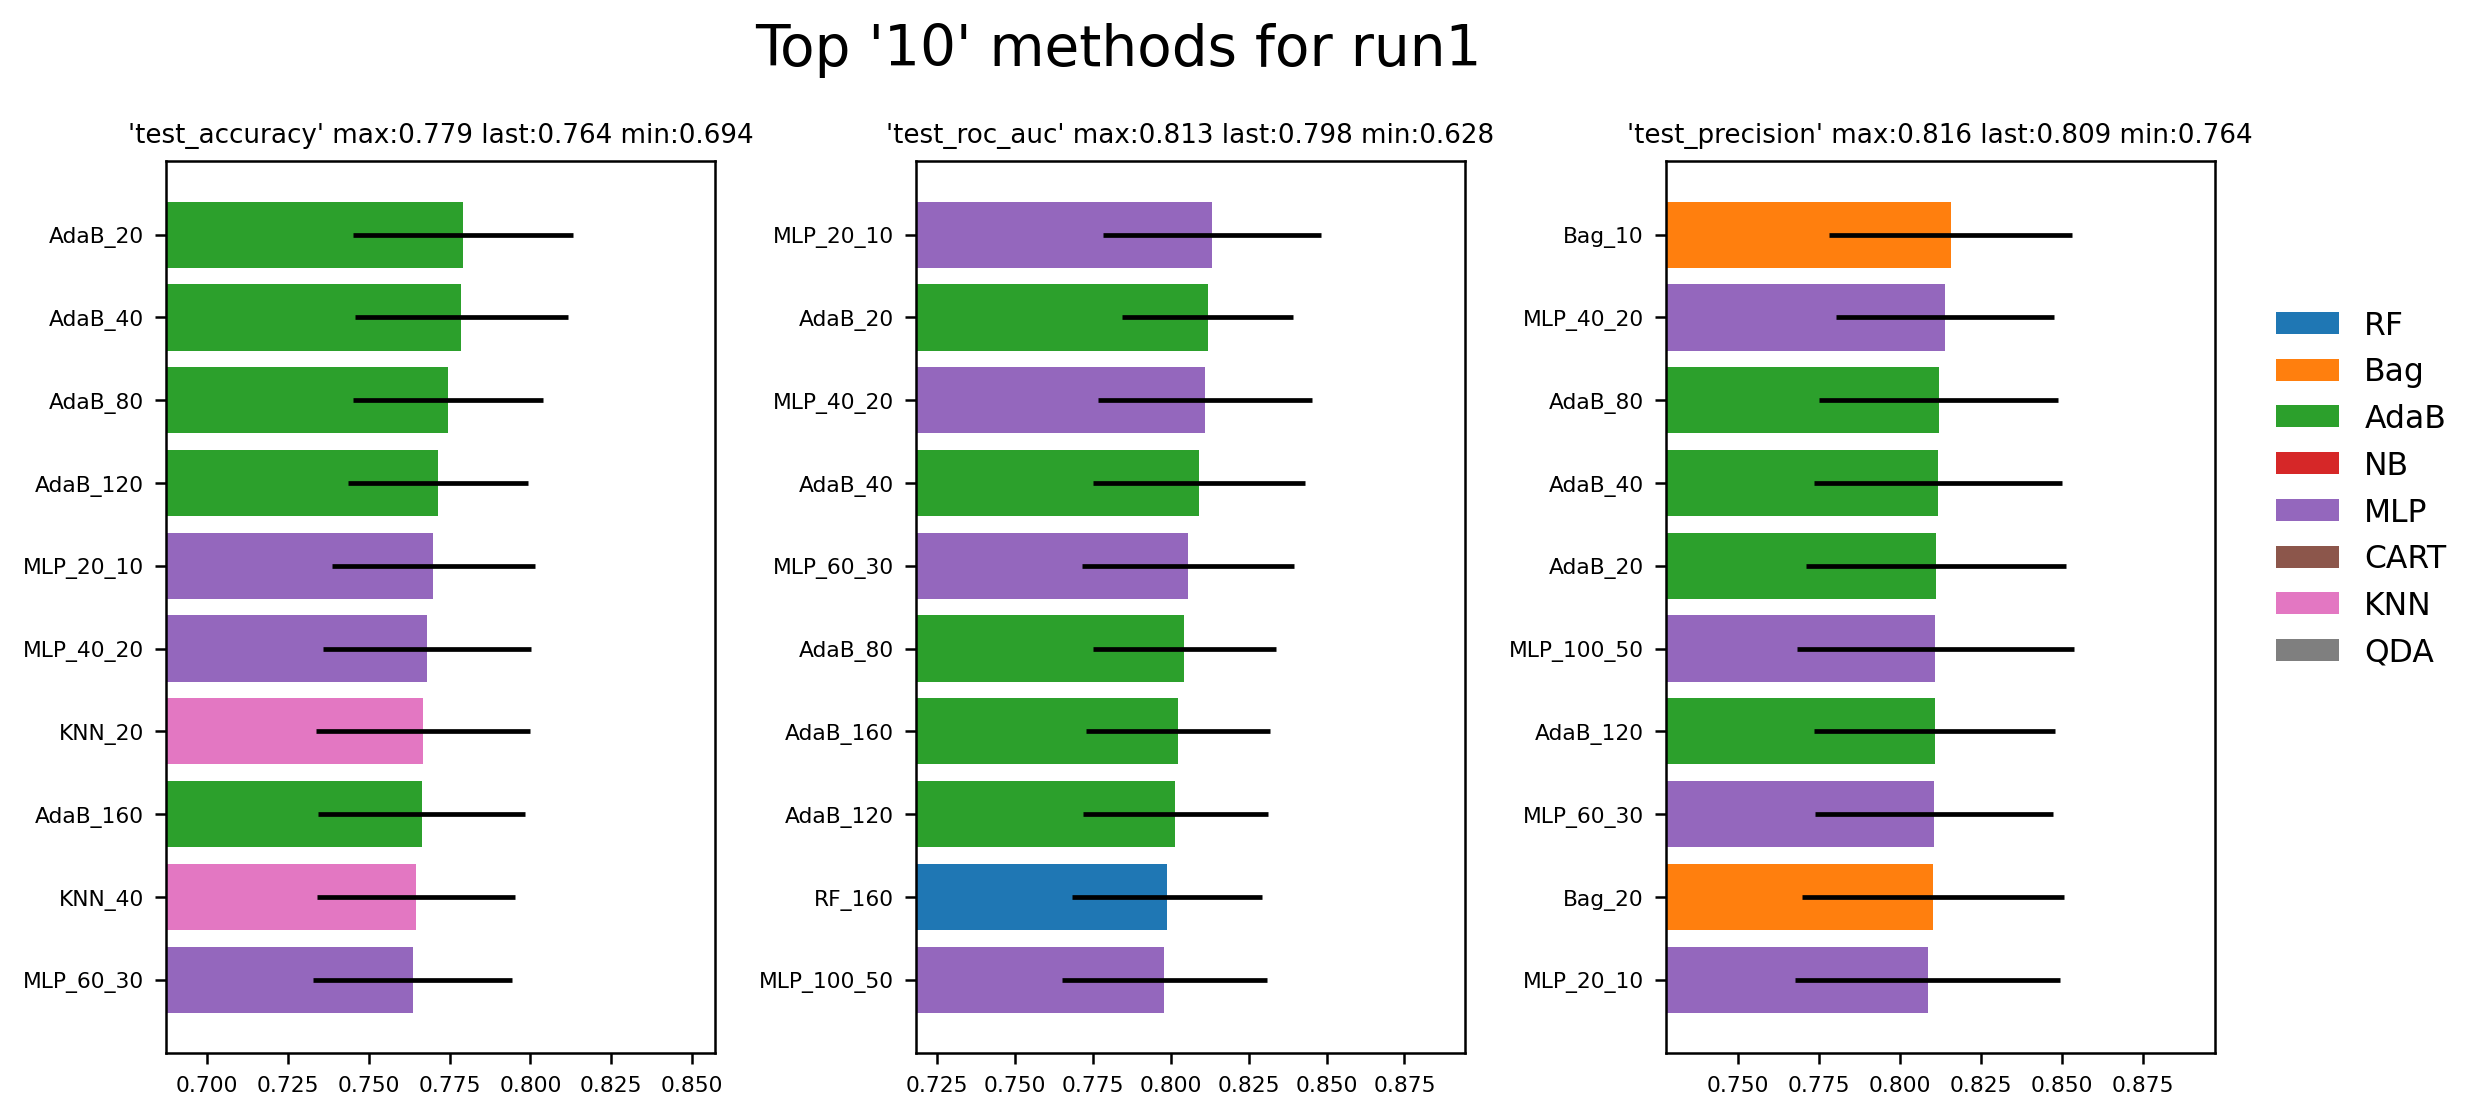

In [39]:
run1=taa.run_classifiers(taa.CLASSIFIERS, xtrain_trim_ss, ytrain)
taa.results_run_clfs(run1, "run1", top=10)

# Apprentissage supervisé : Données hétérogènes

## Chargement des données et préparation

In [40]:
df_credit_het = pd.read_csv(CREDIT_SCORE_HET, sep="\t", header=None, na_values="?")

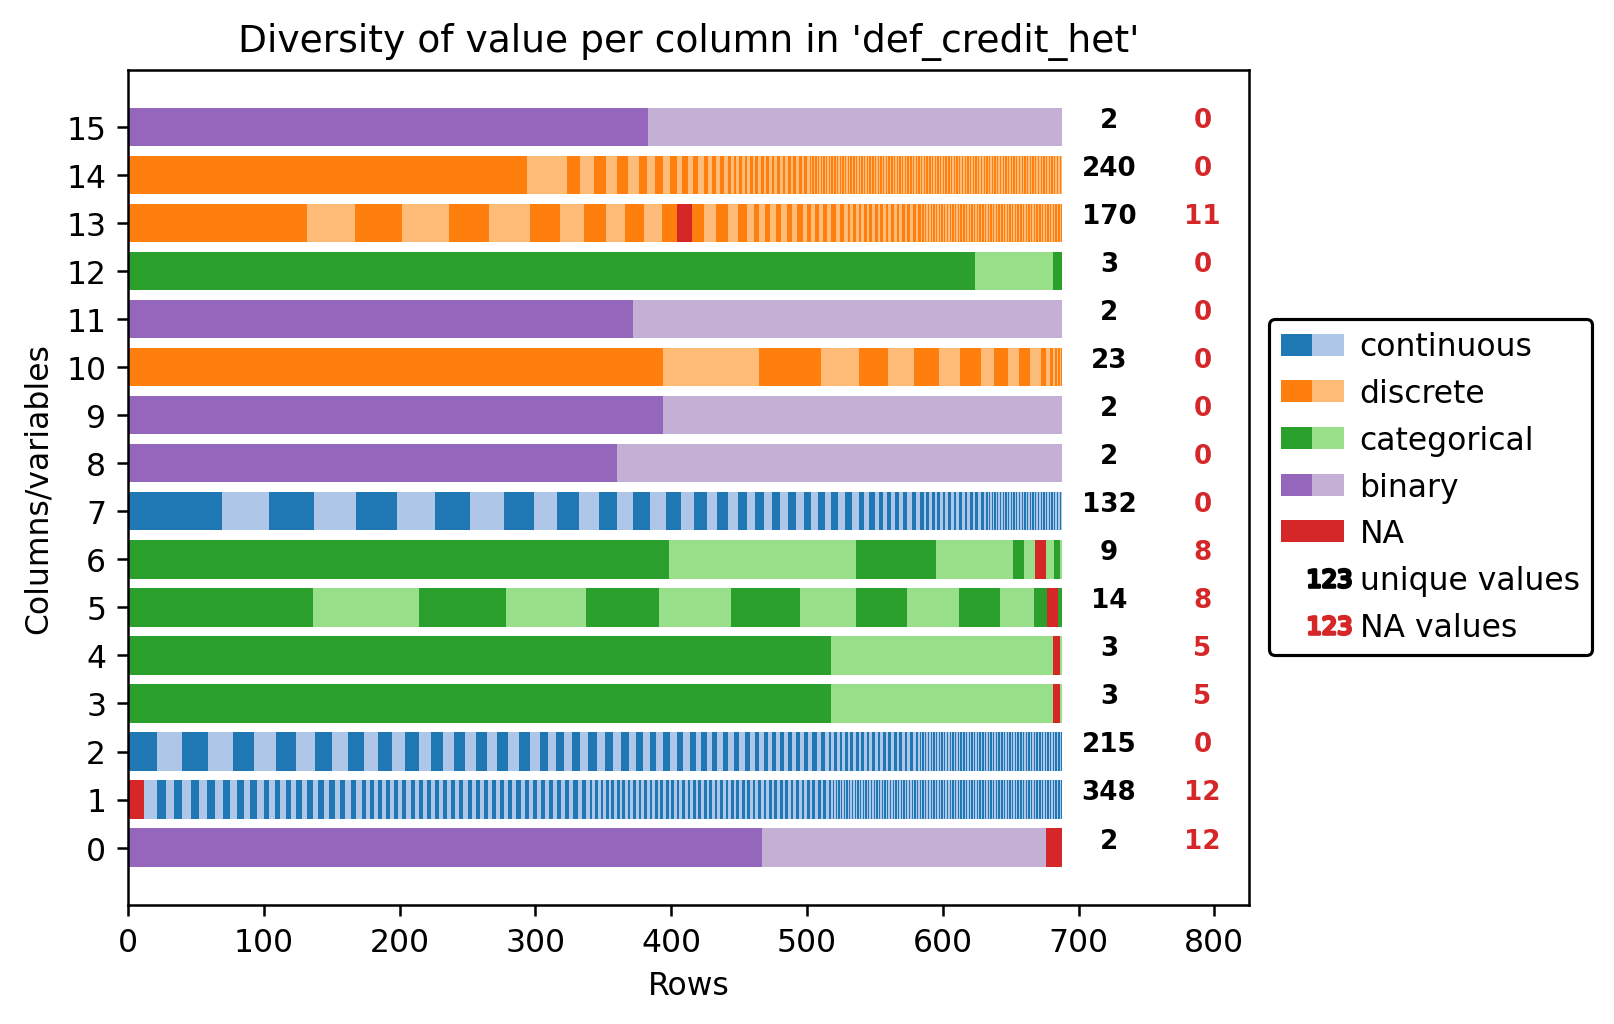

In [41]:
taa.explore_data(df_credit_het, "def_credit_het")

In [42]:
CAT_COLS = [0, 3, 4, 5, 6, 8, 9, 11, 12]
NUM_COLS = [1, 2, 7, 10, 13, 14]

# to numpy array
X, Y = df_credit_het.values[:, :15], df_credit_het.values[:, 15]

# separate into X_num, X_cat and Y arrays
X_num = X[:, NUM_COLS]
X_num = X_num.astype(np.float64)

X_cat = X[:, CAT_COLS]

Y[Y == "+"] = 1
Y[Y == "-"] = 0
Y = Y.astype(np.float64)

# without NA
without_na = ~np.isnan(X_num).any(axis=1)
X_num_nona = X_num[without_na]
Y_nona = Y[without_na]

## 2) Normalisation des variables continues :

Par continues on entend toute valeurs numériques trouvées dans le jeu de donnée.

run_classifiers: Loaded from ../res/__cache_pickle__/run_classifiers/a4dc429443d32e4365cd9d0652c2fc7912097739.pkl
run_classifiers: Loaded from ../res/__cache_pickle__/run_classifiers/516188f3a2c4f289cc8f40d0eca51bb023fbd1da.pkl
run_classifiers: Loaded from ../res/__cache_pickle__/run_classifiers/2dc44baca86476855055761a692ea924bba404d9.pkl


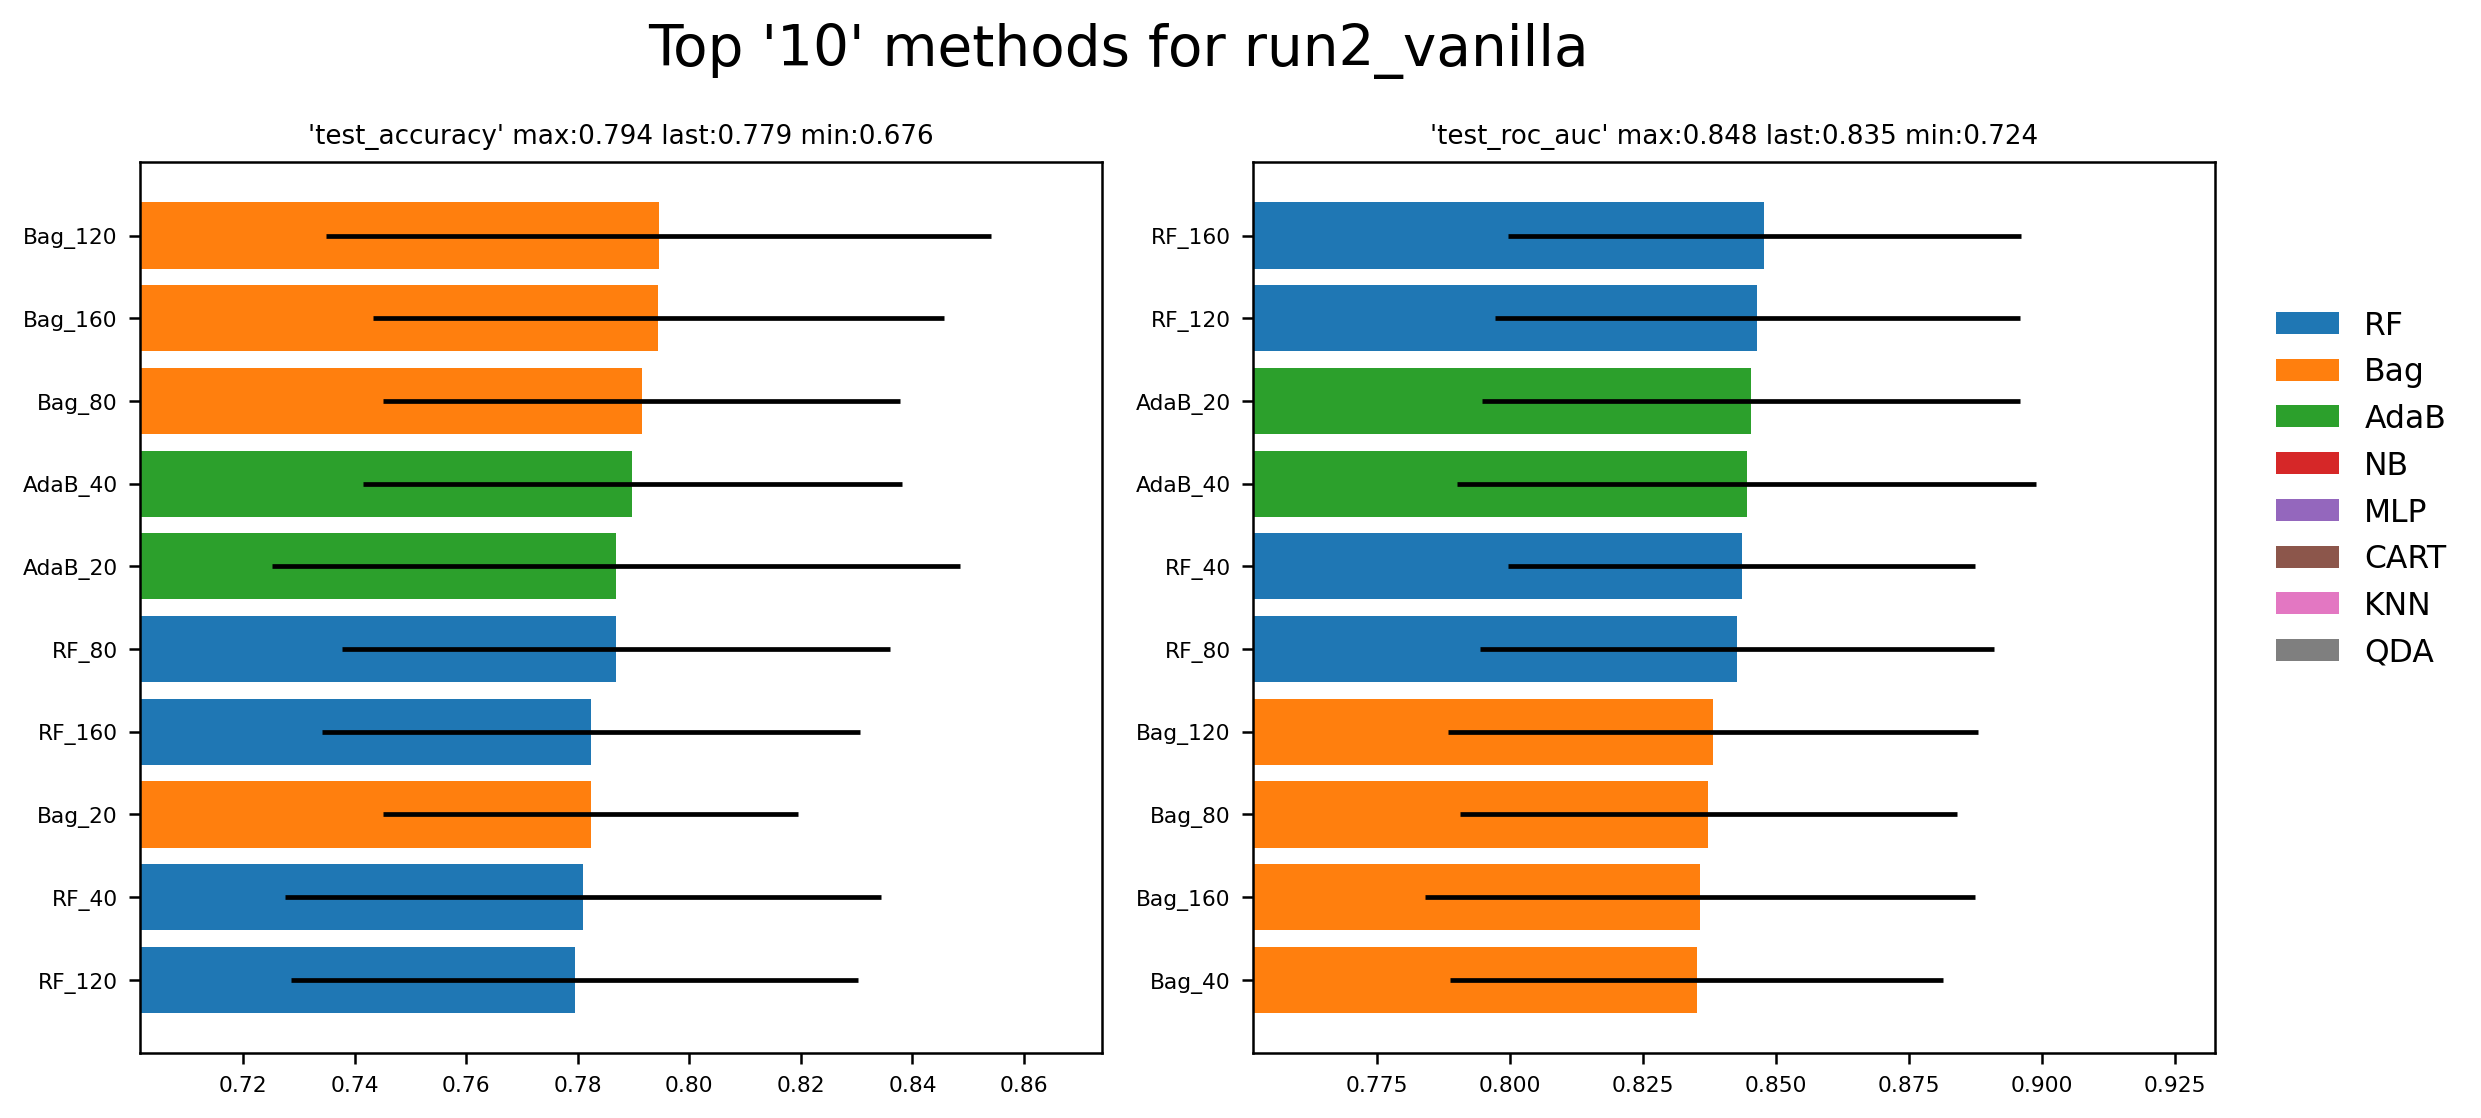

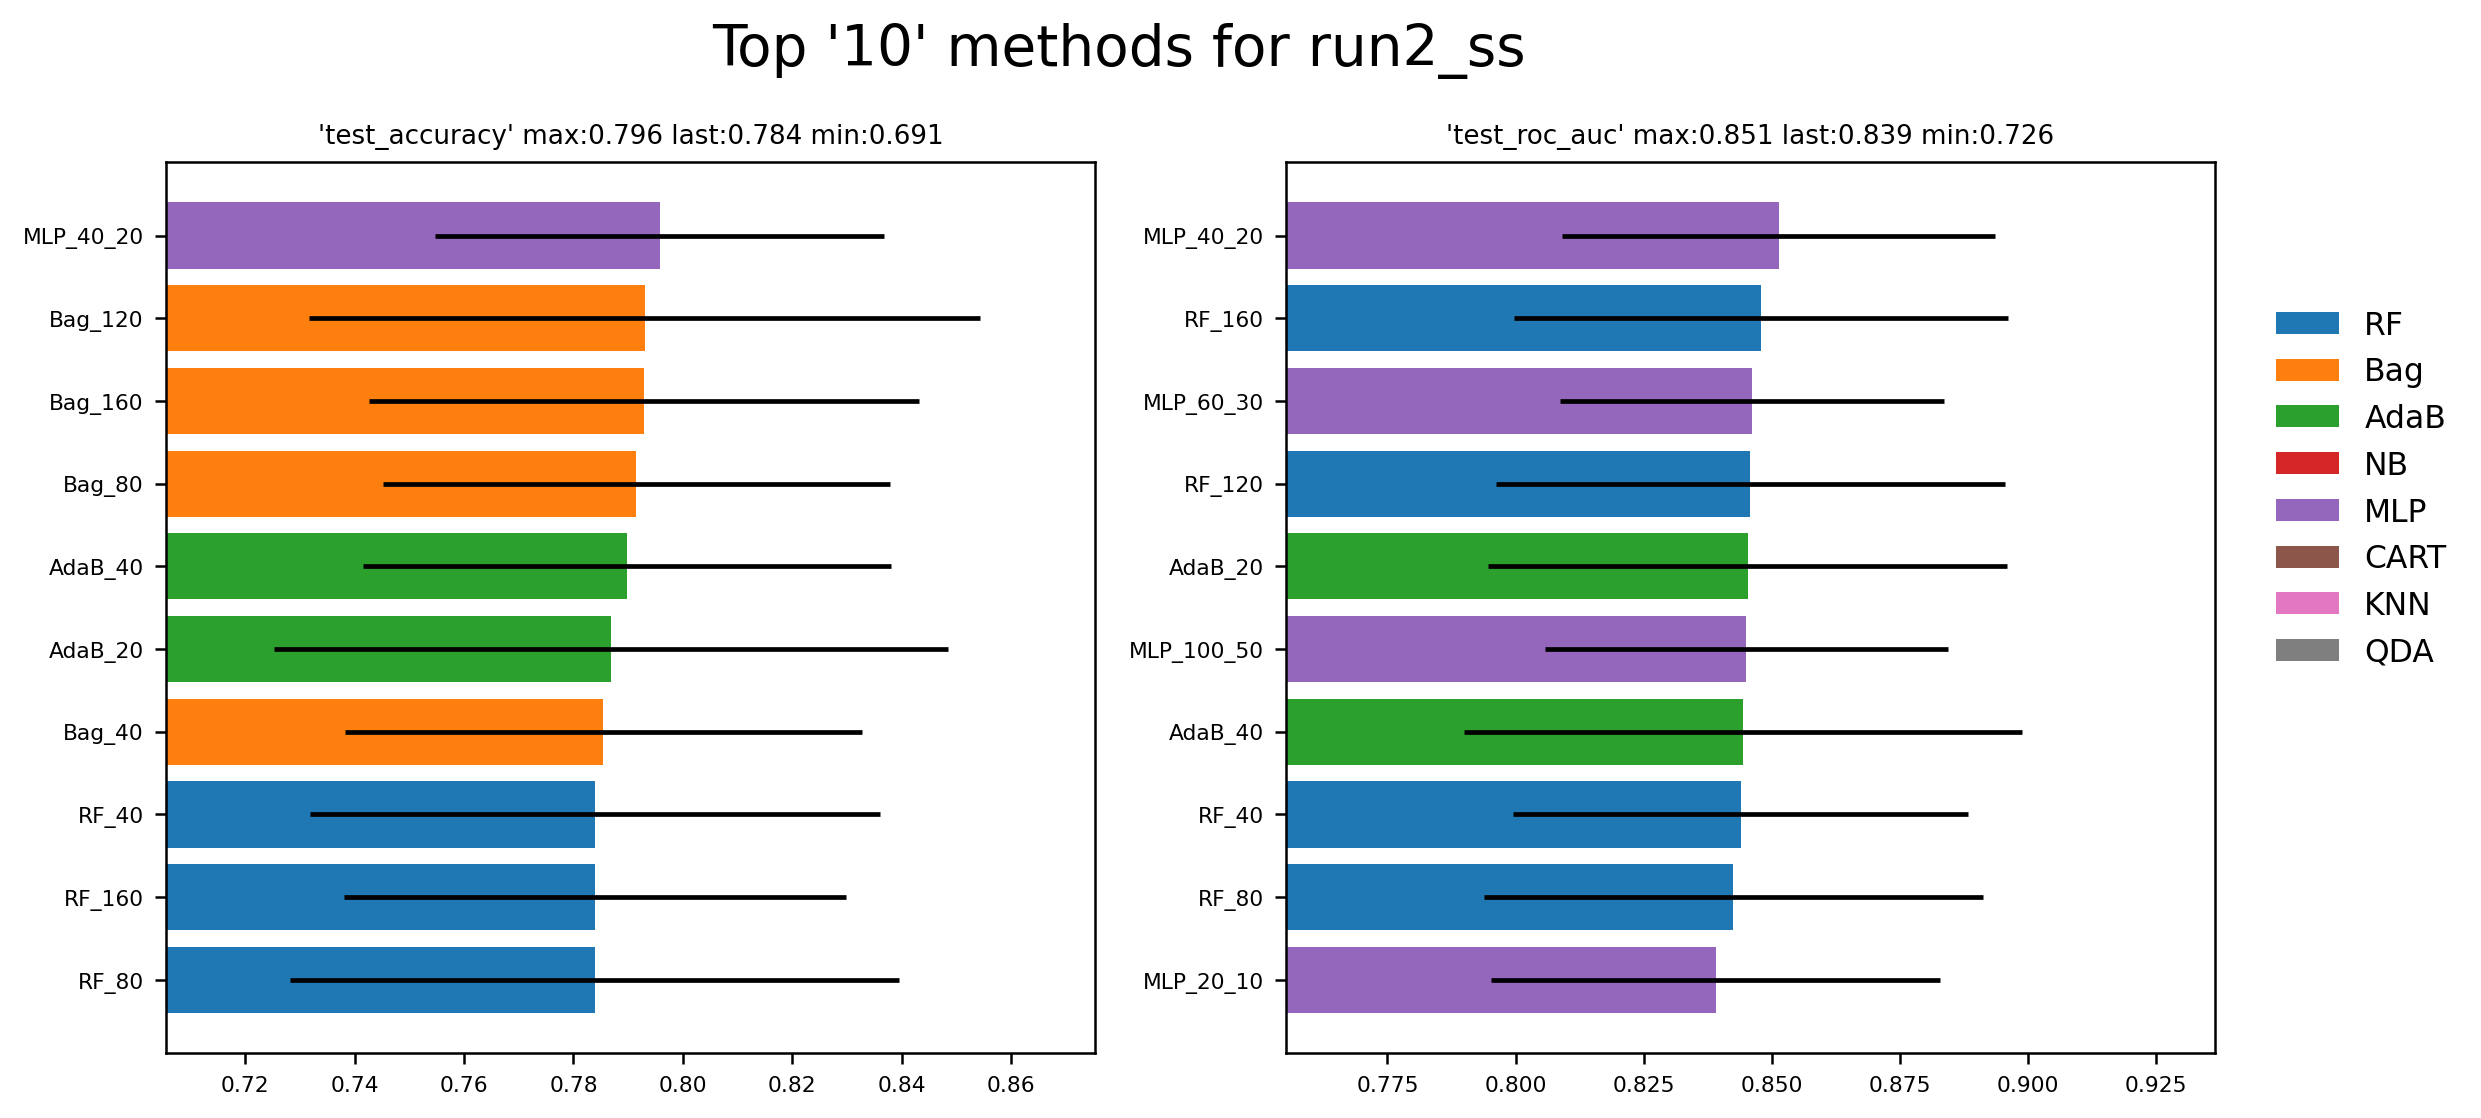

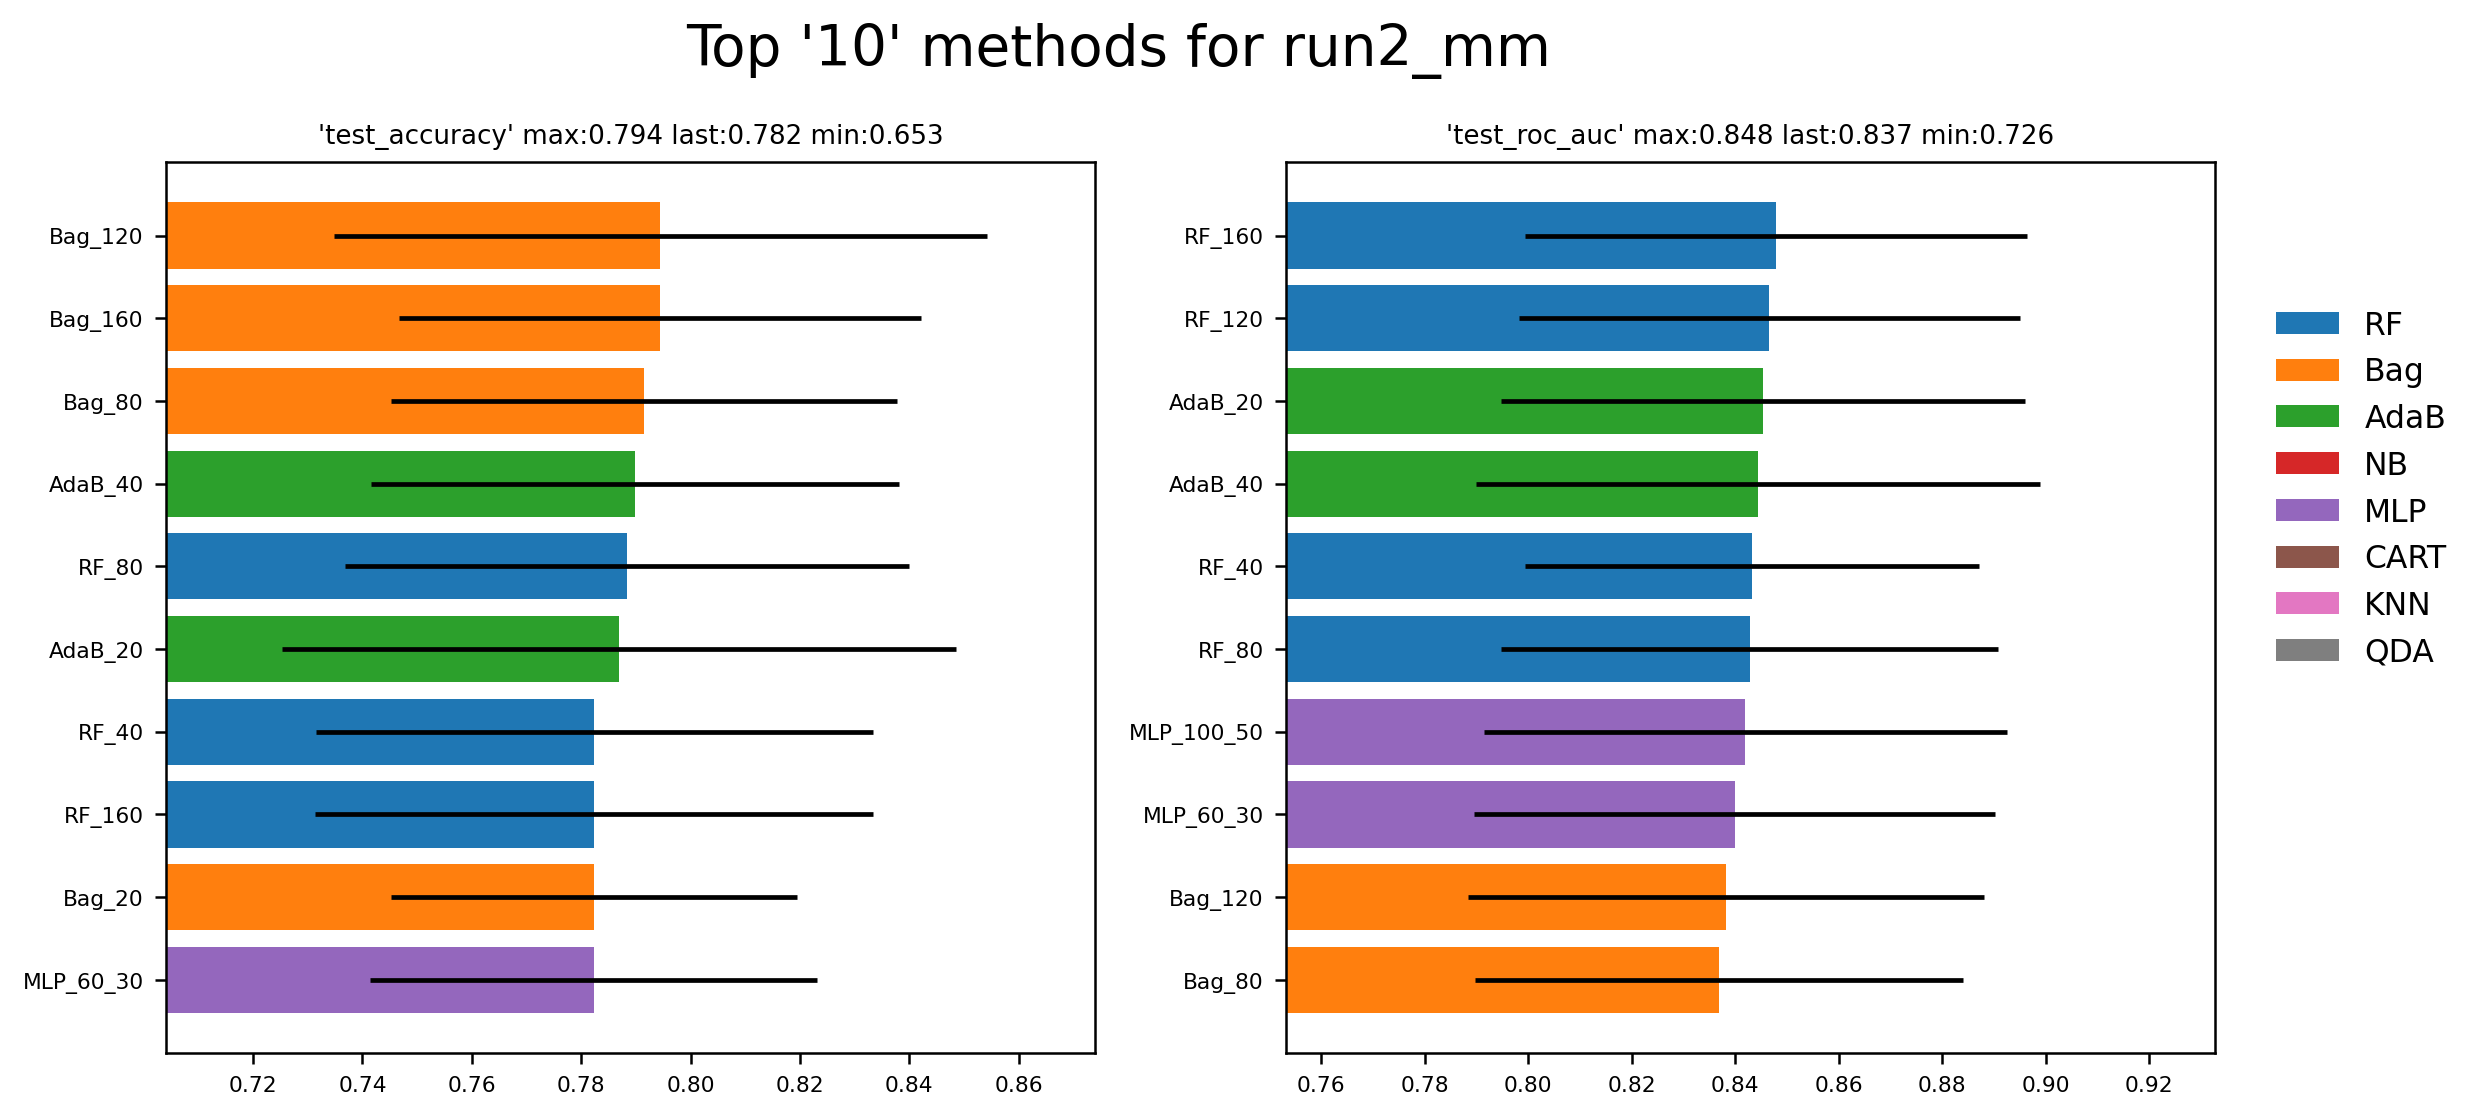

In [43]:
# Standard scaling X_num
stdScale=StandardScaler()
X_num_nona_ss = stdScale.fit_transform(X_num_nona)

# Min max scaling X_num
mmScale= MinMaxScaler()
X_num_nona_mm = mmScale.fit_transform(X_num_nona)

# run
run2_vanilla = taa.run_classifiers(taa.CLASSIFIERS, X_num_nona, Y_nona)
run2_ss = taa.run_classifiers(taa.CLASSIFIERS, X_num_nona_ss, Y_nona)
run2_mm = taa.run_classifiers(taa.CLASSIFIERS, X_num_nona_mm, Y_nona)

taa.results_run_clfs(run2_vanilla, "run2_vanilla", scores=["test_accuracy", "test_roc_auc"])
taa.results_run_clfs(run2_ss, "run2_ss", scores=["test_accuracy", "test_roc_auc"])
taa.results_run_clfs(run2_mm, "run2_mm", scores=["test_accuracy", "test_roc_auc"])

## Traitement de données manquantes : 

In [44]:
from sklearn.impute import SimpleImputer

# for categorical data
X_cat_imp = np.copy(X_cat)
X_cat_imp[pd.isna(X_cat_imp)] = "NA"
for i in range(len(CAT_COLS)):
    unique_val, val_idx = np.unique(X_cat_imp[:, i], return_inverse=True) 
    X_cat_imp[:, i] = val_idx

imp_cat = SimpleImputer(missing_values=0, strategy='most_frequent') 
X_cat_imp[:, range(5)] = imp_cat.fit_transform(X_cat_imp[:, range(5)])

#  for numerical data
X_num_imp = np.copy(X_num)
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean') 
X_num_imp = imp_num.fit_transform(X_num_imp)

## Traitement de variables catégorielles :

run_classifiers: Loaded from ../res/__cache_pickle__/run_classifiers/4b270f72d21f01d355f26ffac63dbded1459039d.pkl
run_classifiers: Loaded from ../res/__cache_pickle__/run_classifiers/bb07d01fb56e30cab8ae8721e05339ba6d7fe4f9.pkl
run_classifiers: Loaded from ../res/__cache_pickle__/run_classifiers/e6c6ad7ac0e4fdc0a6b4b1bf7cbf6b5baf271f9f.pkl


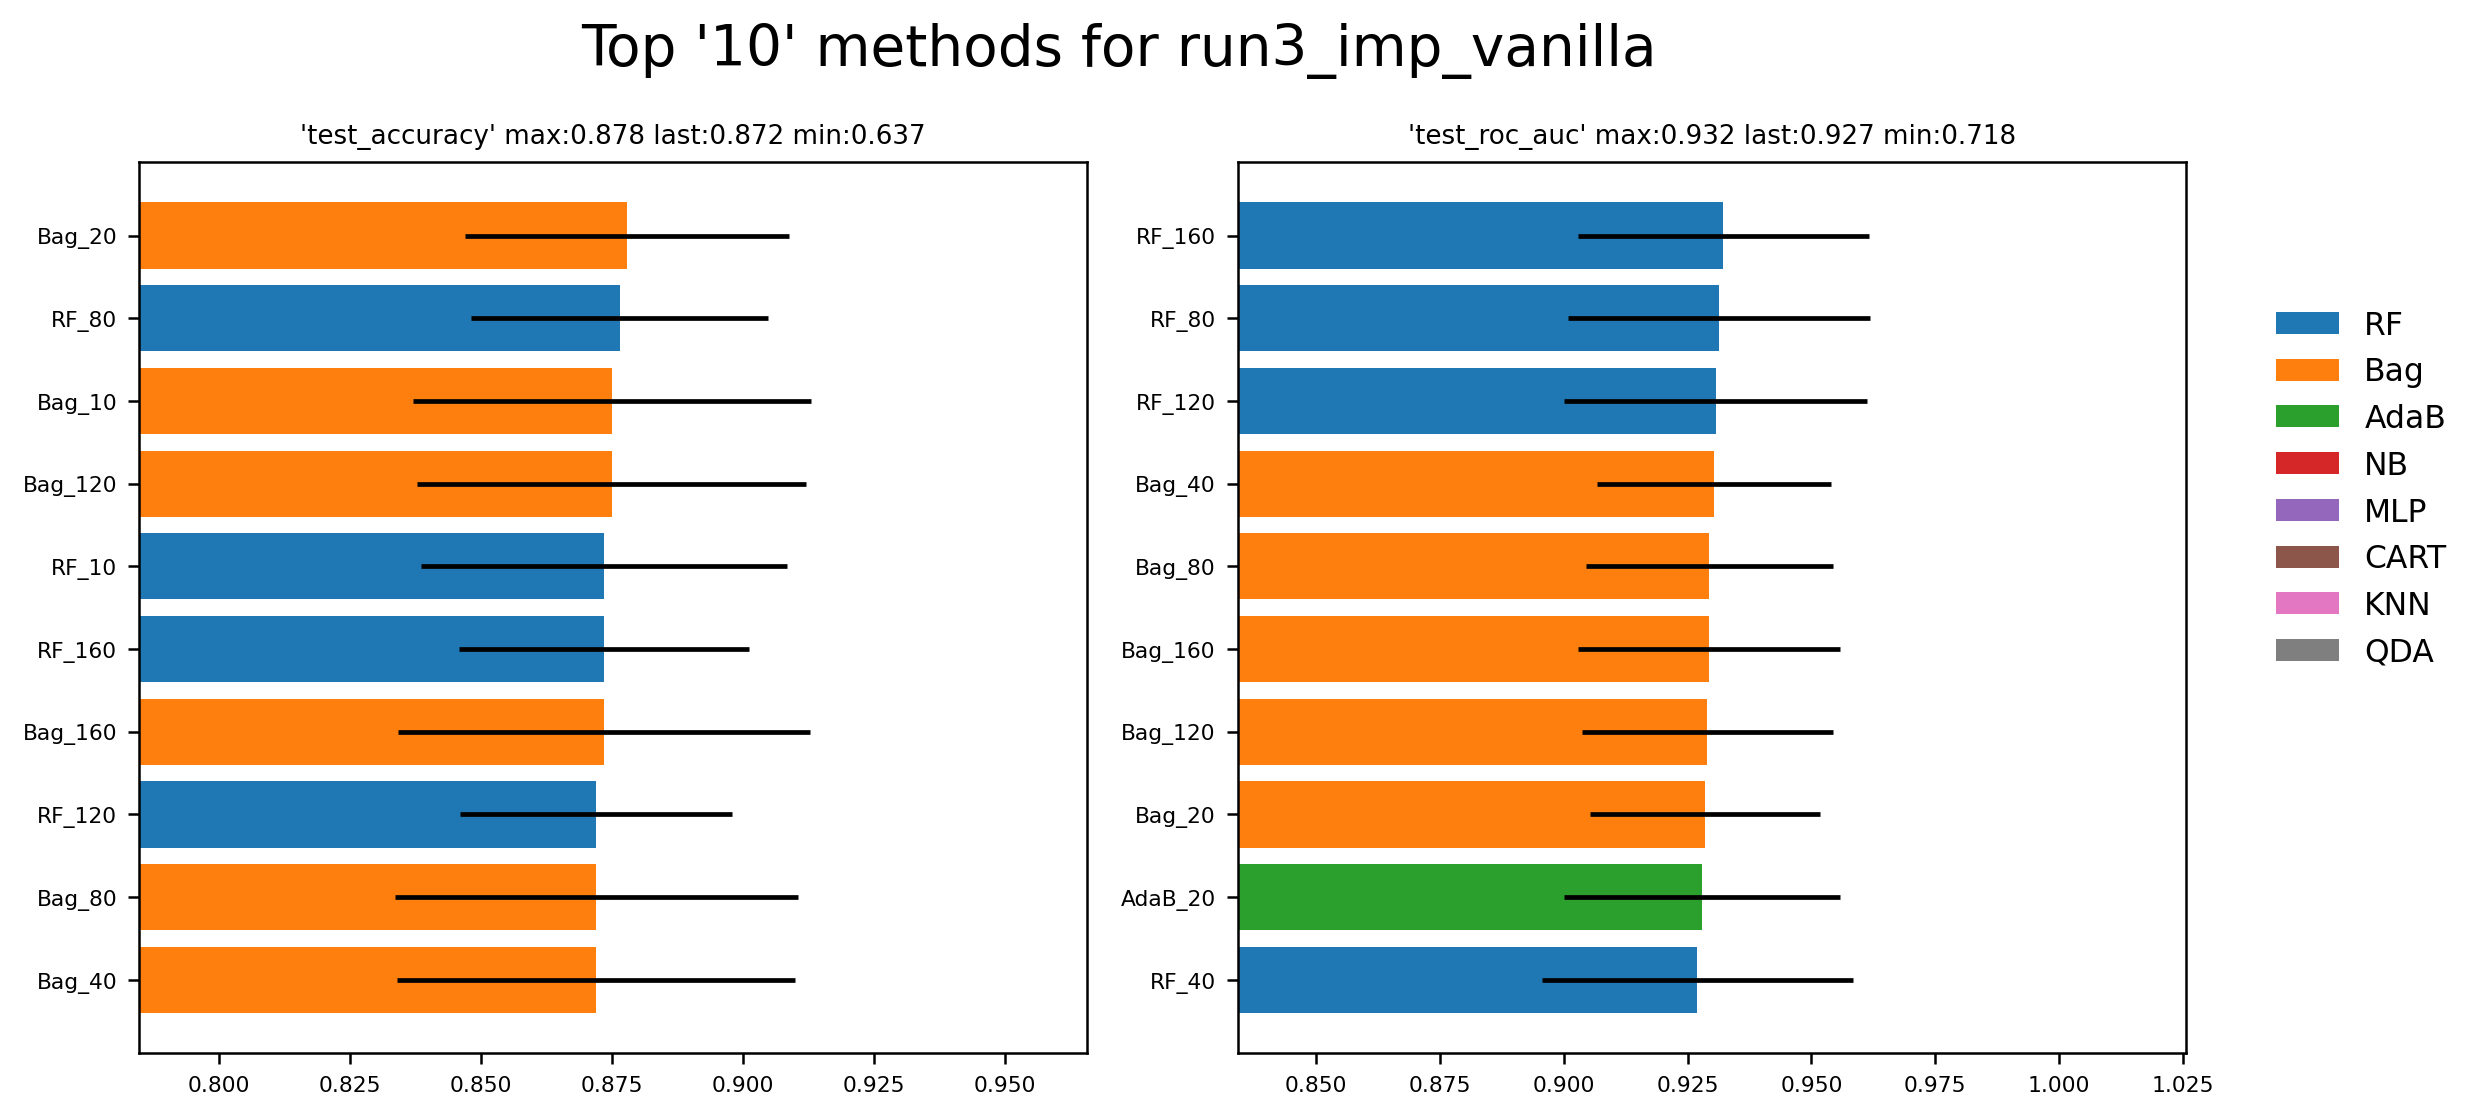

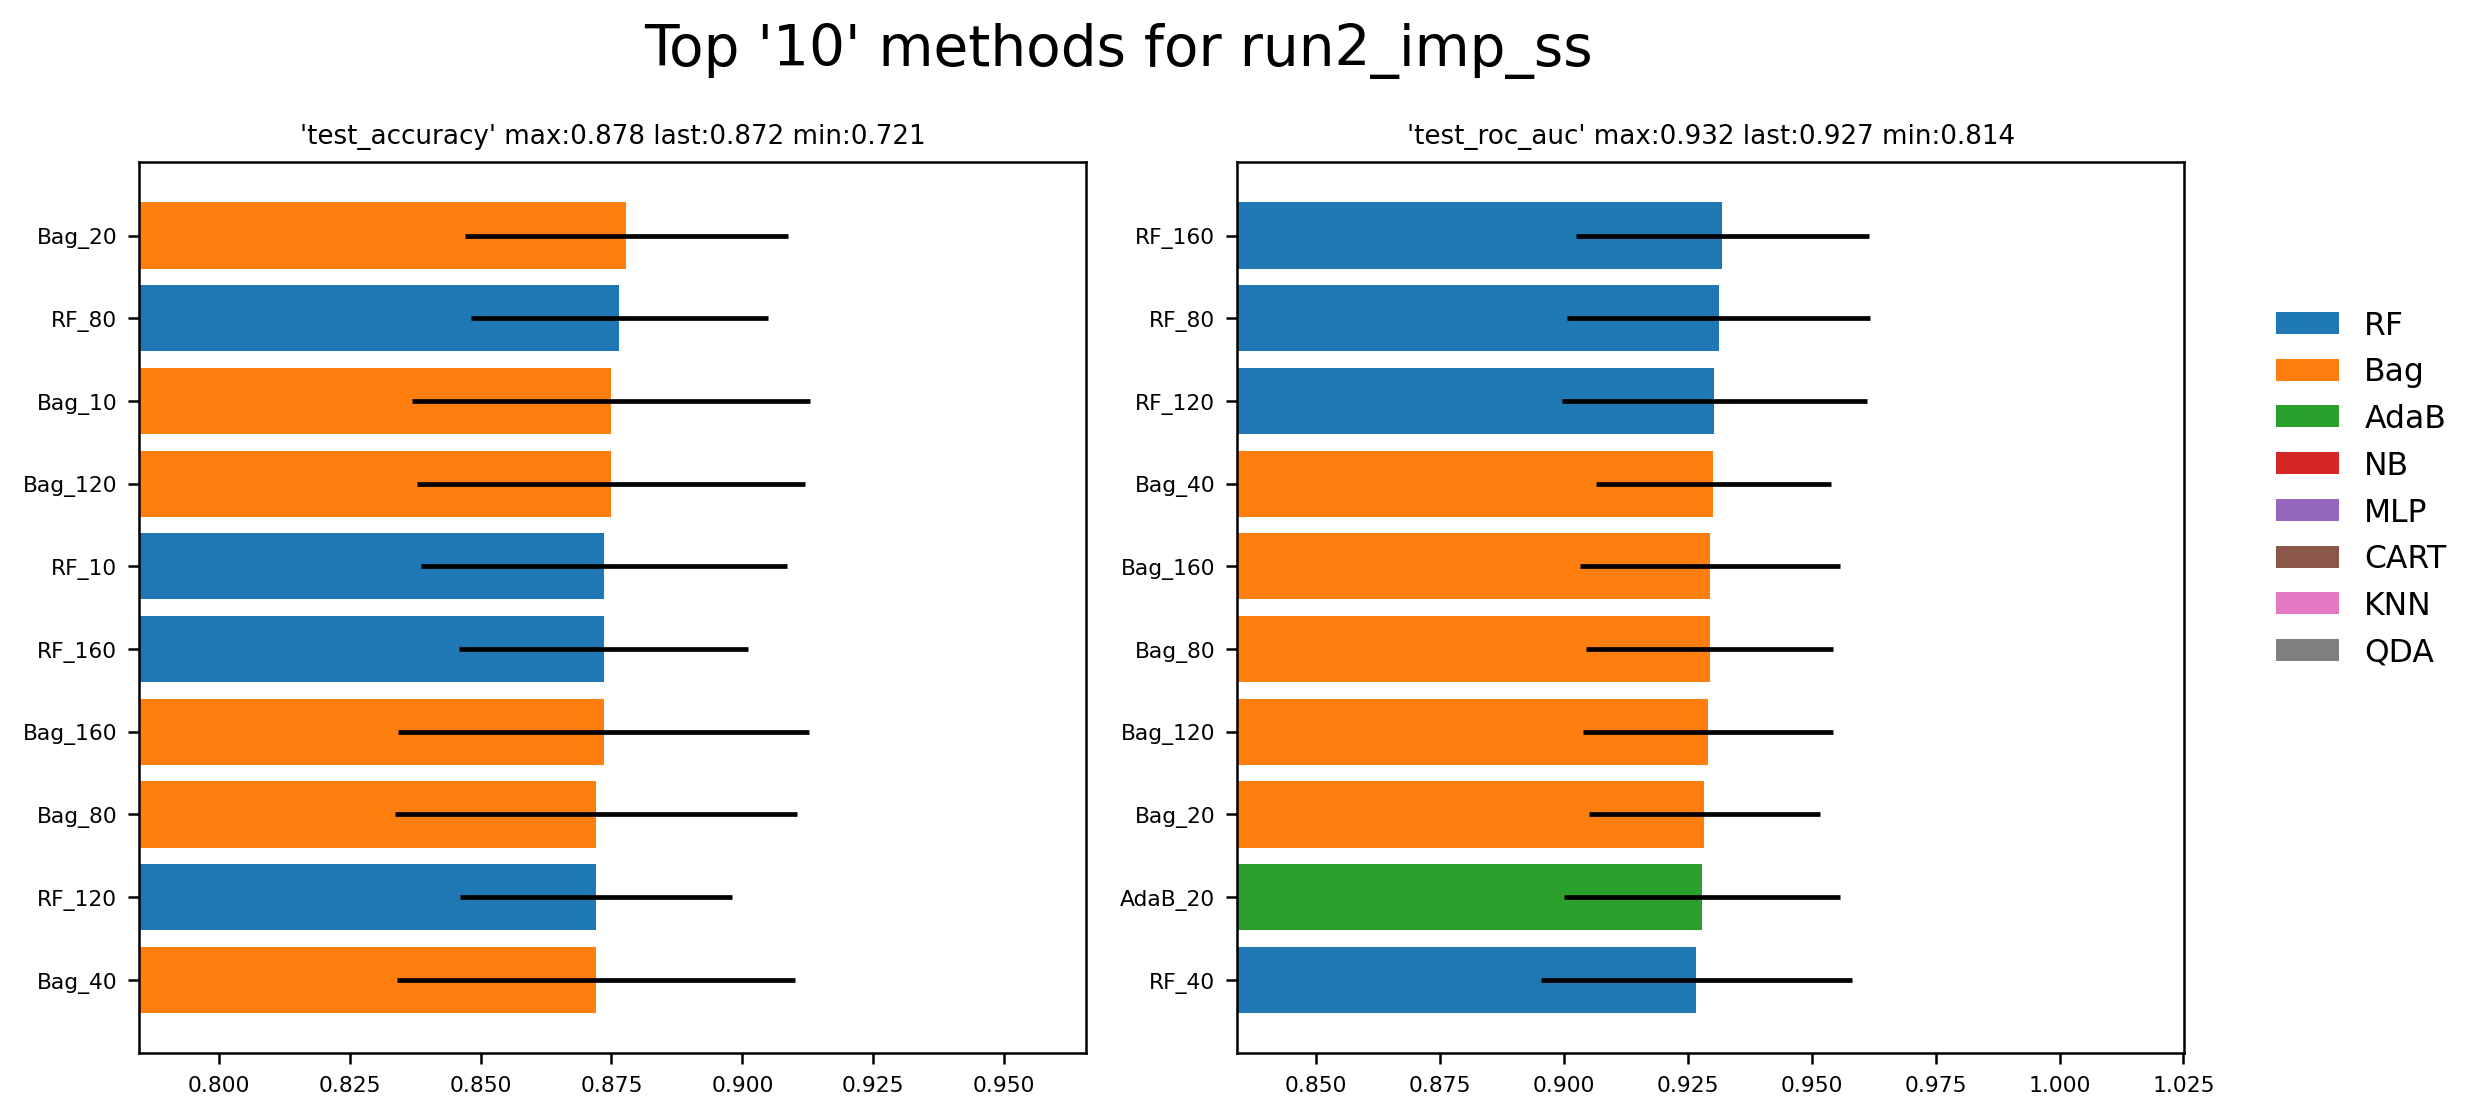

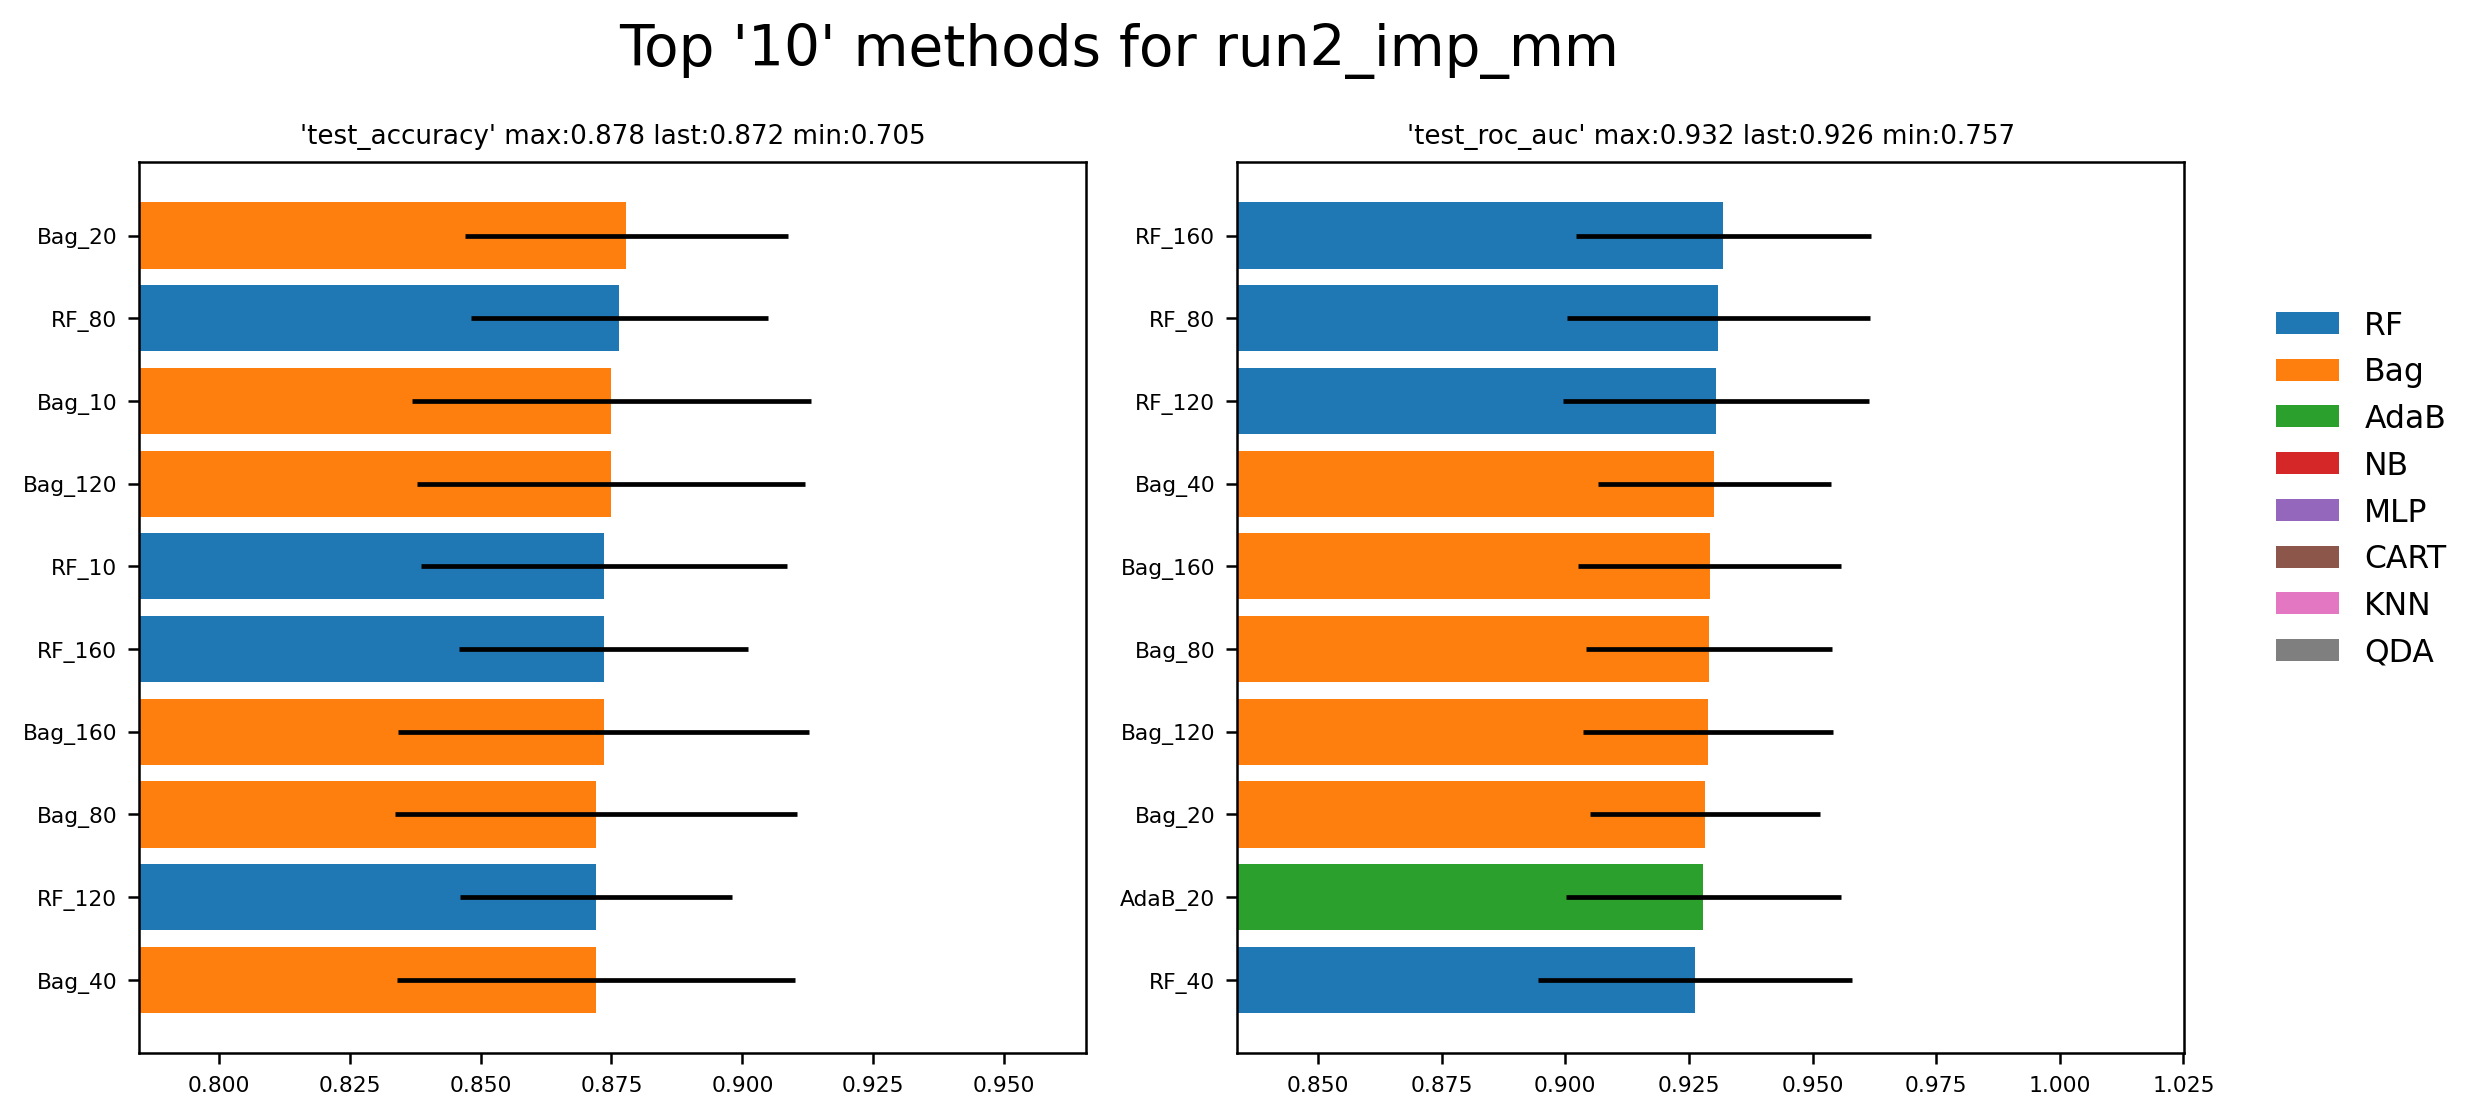

In [45]:
from sklearn.preprocessing import OneHotEncoder

X_cat_imp_bin = OneHotEncoder().fit_transform(X_cat_imp).toarray()

# Standard scaling X_num_imp
stdScale=StandardScaler()
X_num_imp_ss = stdScale.fit_transform(X_num_imp)

# Min max scaling X_num_imp
mmScale= MinMaxScaler()
X_num_imp_mm = mmScale.fit_transform(X_num_imp)

# bind X_cat_imp_binary with X_num_imp
X_combined = np.concatenate((X_num_imp, X_cat_imp_bin), axis=1)
X_combined_mm = np.concatenate((X_num_imp_ss, X_cat_imp_bin), axis=1)
X_combined_ss = np.concatenate((X_num_imp_mm, X_cat_imp_bin), axis=1)

# run
run3_vanilla = taa.run_classifiers(taa.CLASSIFIERS, X_combined, Y)
run3_ss = taa.run_classifiers(taa.CLASSIFIERS, X_combined_mm, Y)
run3_mm = taa.run_classifiers(taa.CLASSIFIERS, X_combined_ss, Y)

taa.results_run_clfs(run3_vanilla, "run3_imp_vanilla", scores=["test_accuracy", "test_roc_auc"])
taa.results_run_clfs(run3_ss, "run2_imp_ss", scores=["test_accuracy", "test_roc_auc"])
taa.results_run_clfs(run3_mm, "run2_imp_mm", scores=["test_accuracy", "test_roc_auc"])

# Apprentissage supervisé sur des données textuelles : Feature engineering et Classification 

## Lecture et préparation des données:

In [46]:
df_spam = pd.read_csv(SPAM, sep = "\t", header = None)
df_spam = df_spam.rename(columns = {0 : "status", 1 : "value"})

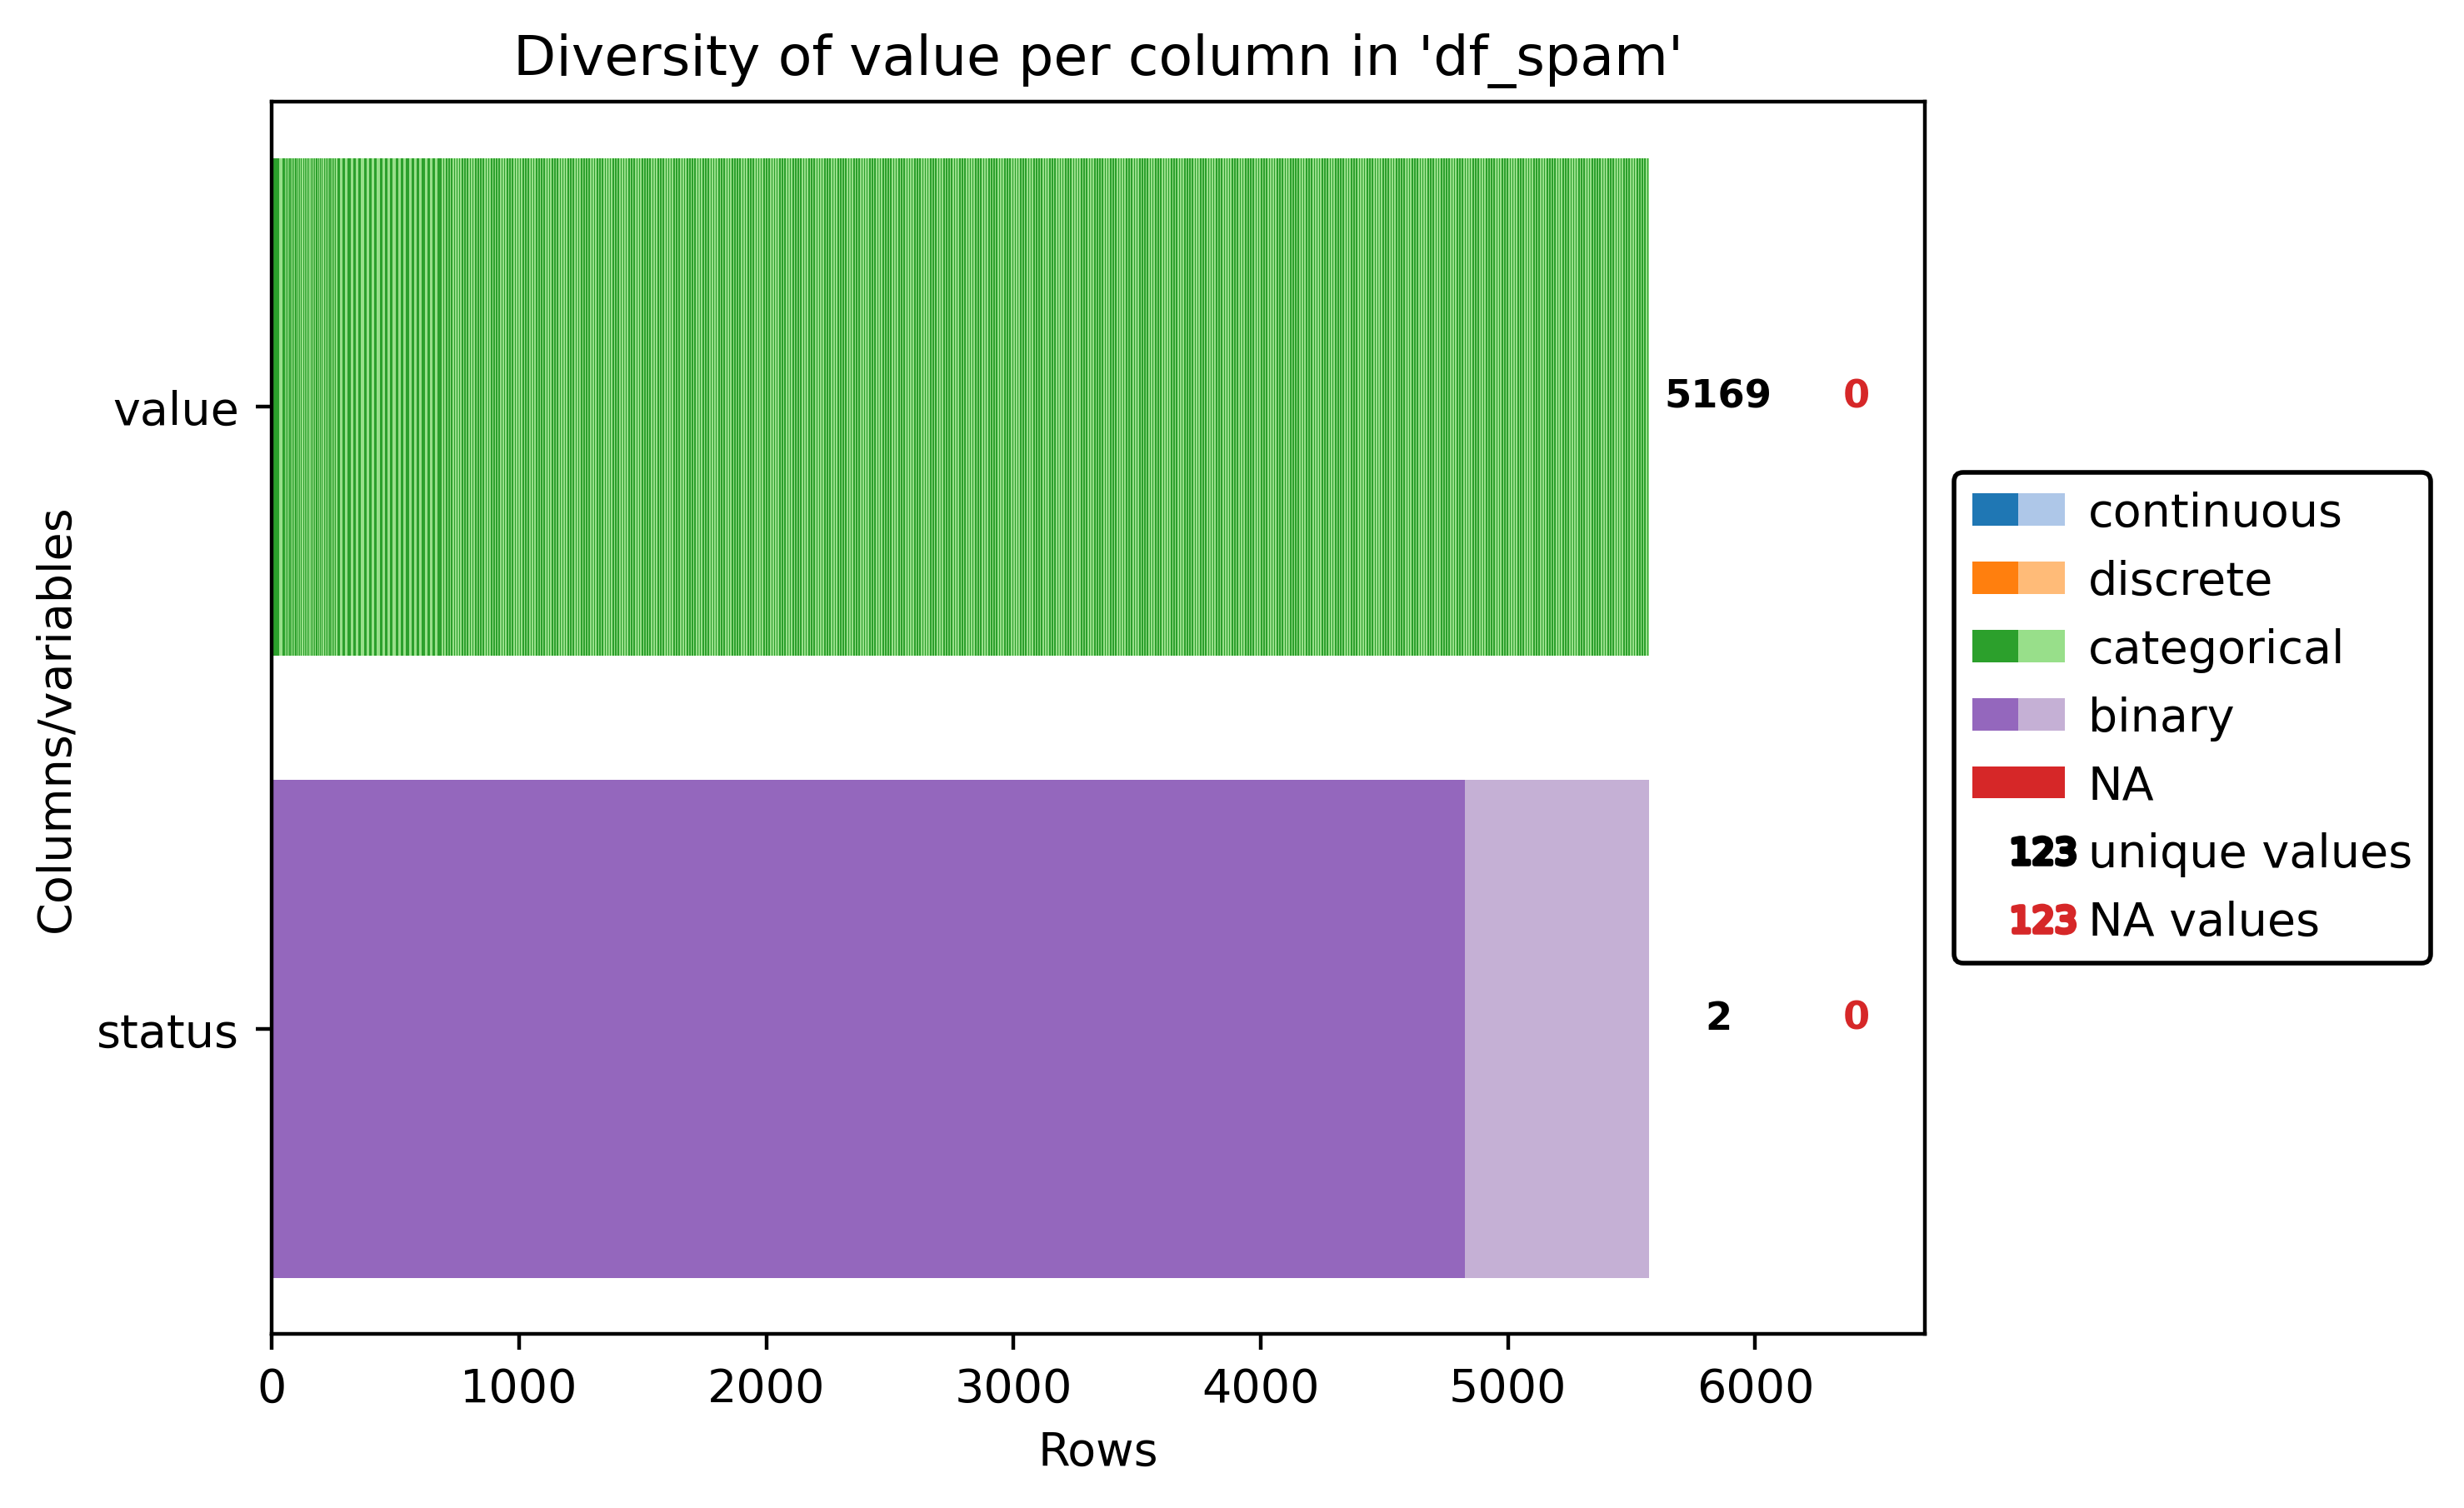

In [47]:
taa.explore_data(df_spam, "df_spam", DPI=400)

var 'status' deseequilibré : ~85% sont en "ham" et ~15% en "spam" -> risque d'avoir des acc haute pour rien
var 'values' unique pour la grande majorité des rows 5169 val unique pour une shape 5572

dans le cadre des spams que veut on ? on veut tous les bloqué (recall max) ou on veut etre sur de ne pas se tromper (precision max) ? jsp ce n'est que des spams


In [48]:
Y = df_spam["status"].values
X = df_spam["value"].values
Y[Y == "spam"] = 1
Y[Y == "ham"] = 0
Y = Y.astype(np.int64)

## CountVectorizer :

run_classifiers: Loaded from ../res/__cache_pickle__/run_classifiers/dc5cf8108c6410f17f888e6ae2d7c4d3b20a36be.pkl


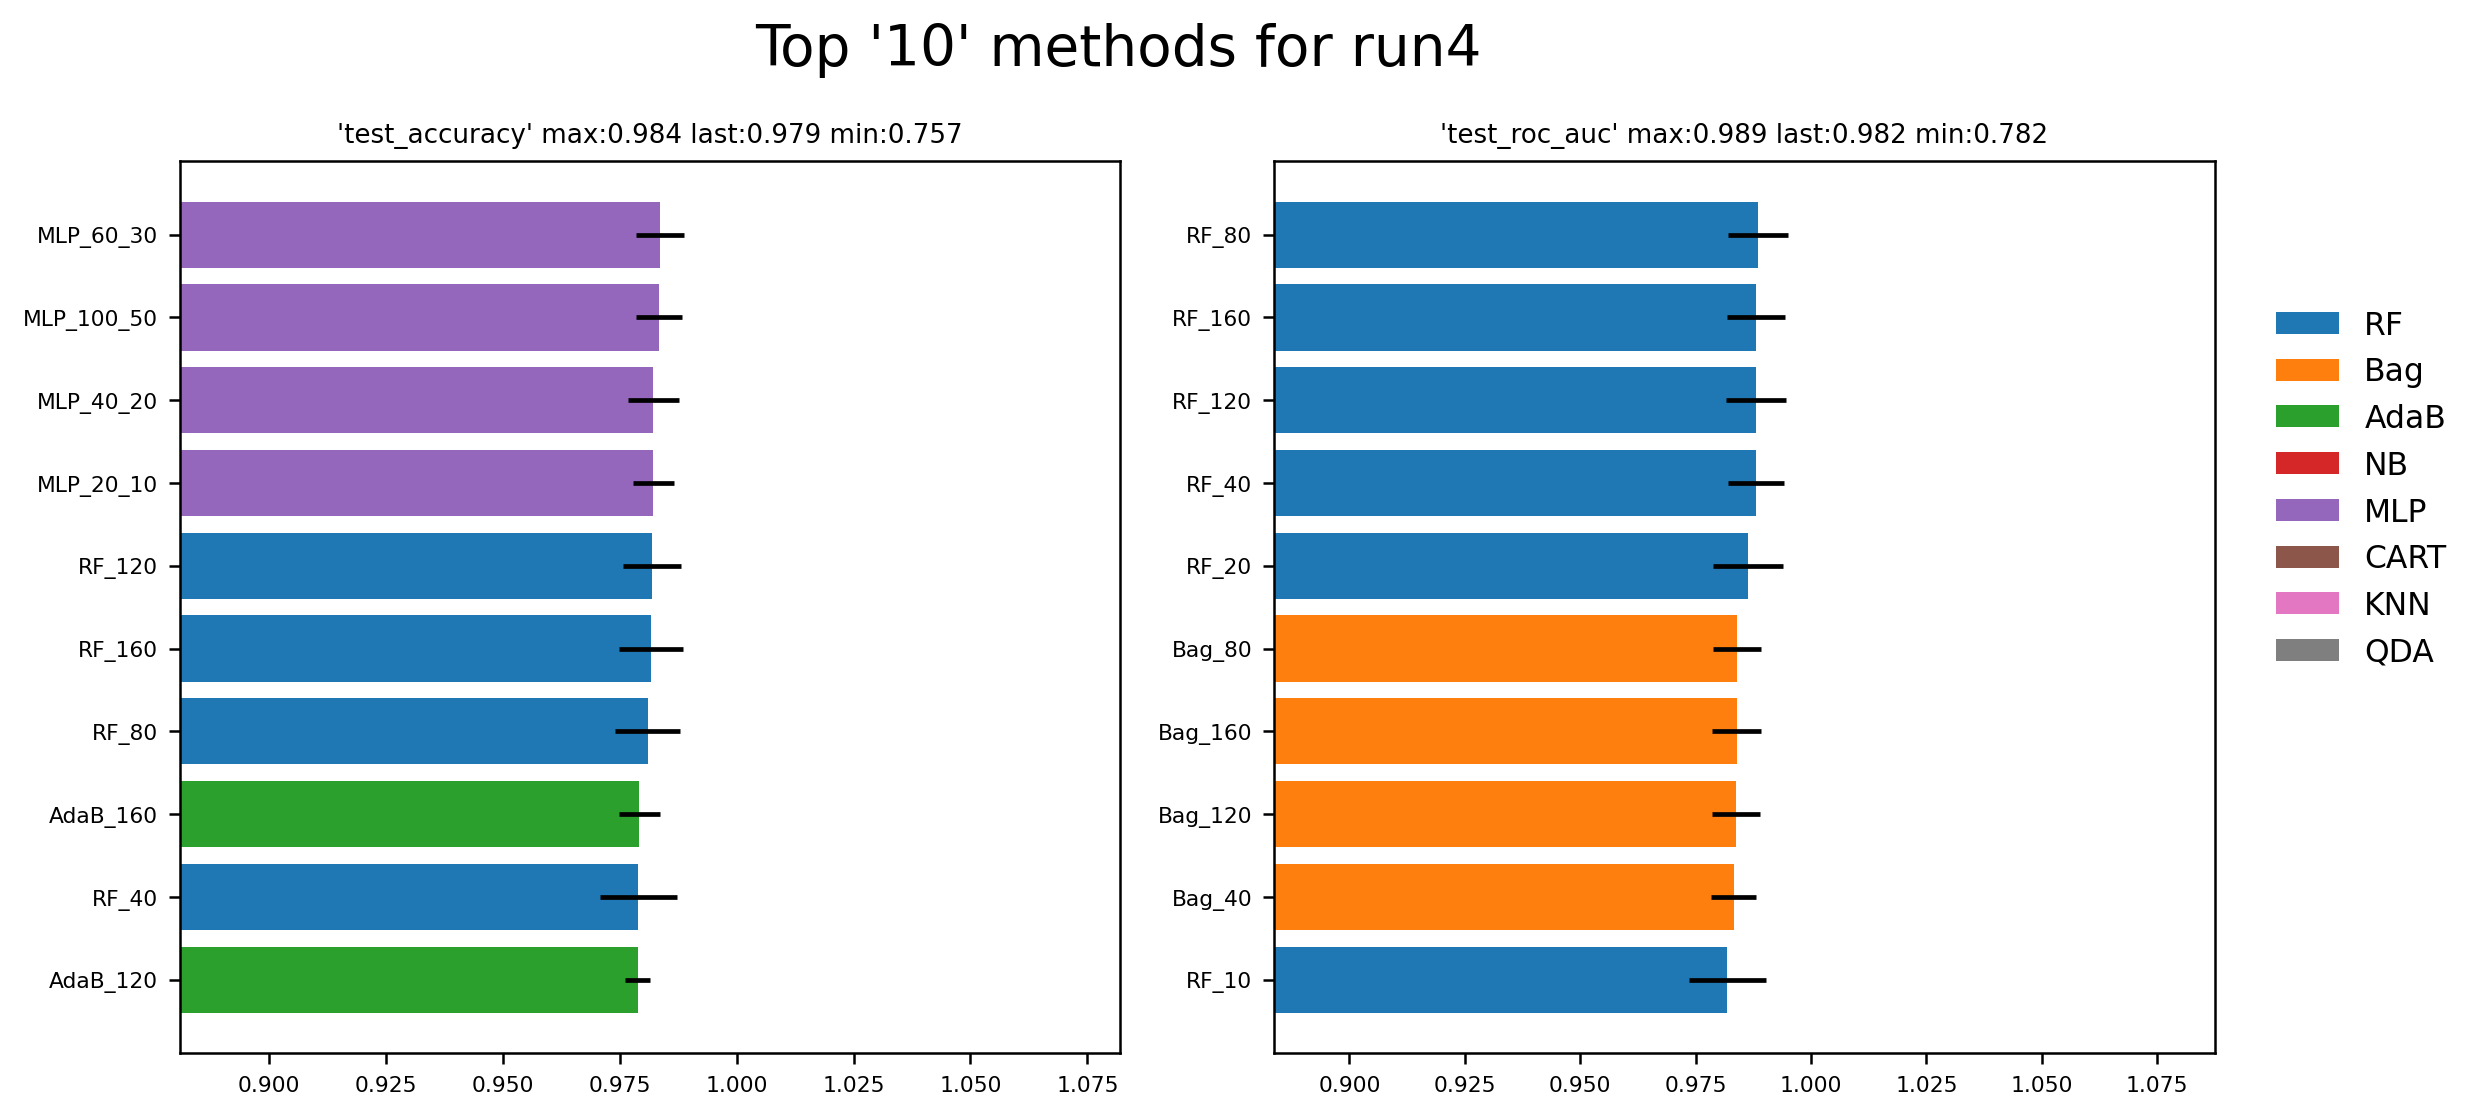

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', min_df = 10)
X_vec = vectorizer.fit_transform(X)
X_vec = X_vec.toarray()

run4 = taa.run_classifiers(taa.CLASSIFIERS, X_vec, Y)
taa.results_run_clfs(run4, "run4", scores=["test_accuracy", "test_roc_auc"])

## Tf–idf term weighting : 

run_classifiers: Loaded from ../res/__cache_pickle__/run_classifiers/5b2ef557c344f070e0ab0c5125c76d202bd5c69d.pkl


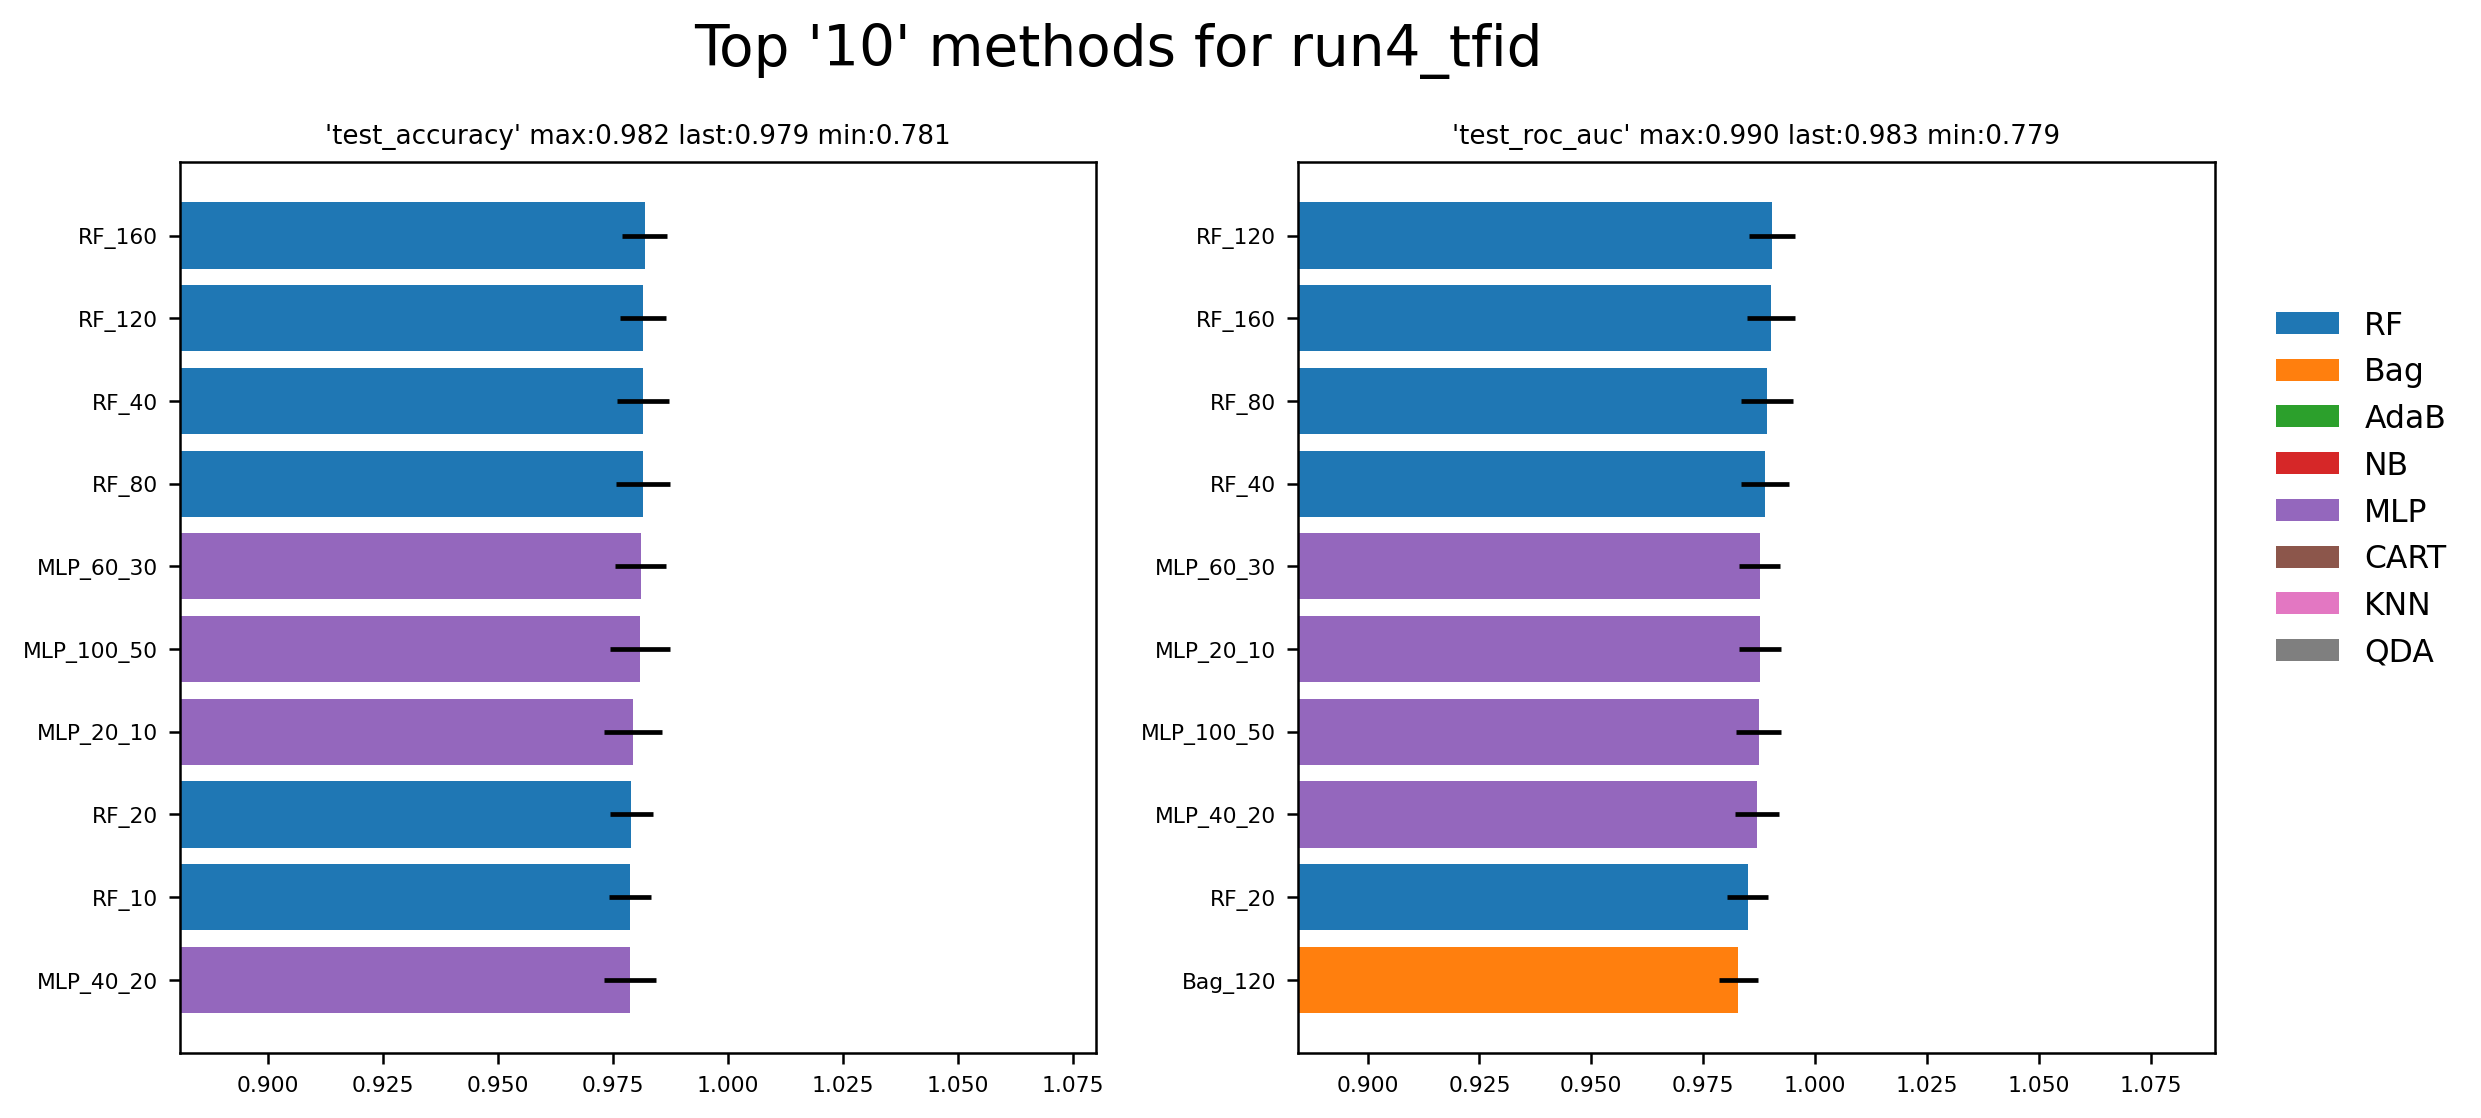

In [50]:
from sklearn.feature_extraction.text import TfidfTransformer

tfid = TfidfTransformer(smooth_idf=False)
X_vec_tfid = tfid.fit_transform(X_vec)
X_vec_tfid = X_vec_tfid.toarray()

run4_tfid = taa.run_classifiers(taa.CLASSIFIERS, X_vec_tfid, Y)
taa.results_run_clfs(run4_tfid, "run4_tfid", scores=["test_accuracy", "test_roc_auc"])

## TruncatedSVD :

run_classifiers: Loaded from ../res/__cache_pickle__/run_classifiers/d3ff944581013cf083c311b568ab170ad0d6ce76.pkl


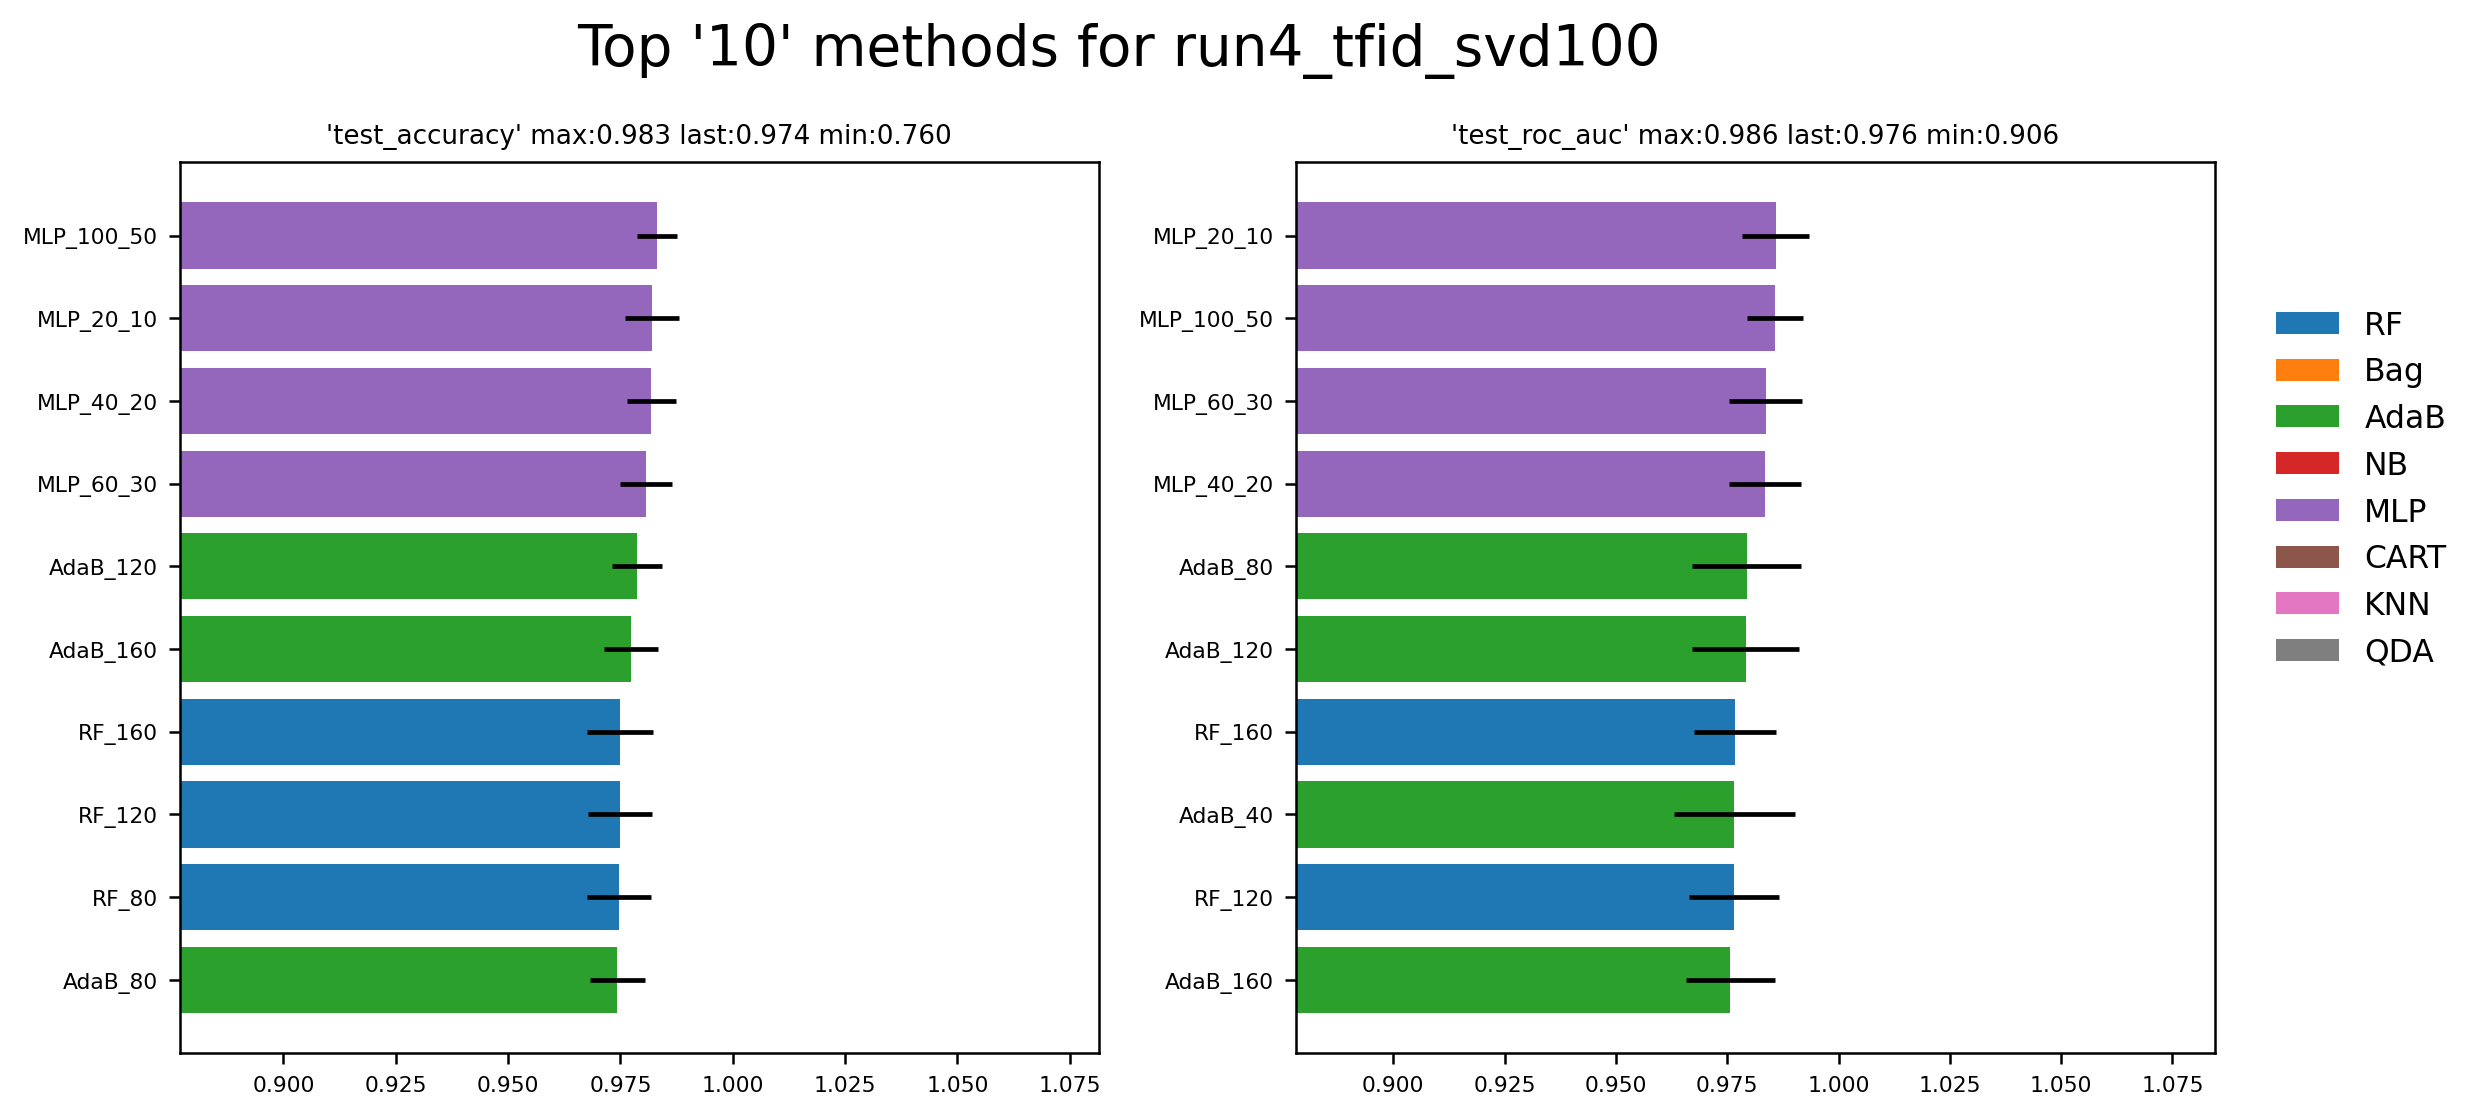

In [51]:
from sklearn.decomposition import TruncatedSVD

# 100 concepts
svd100 = TruncatedSVD(n_components=100, n_iter=20, random_state=1)
X_vec_tfid_svd100 = svd100.fit_transform(X_vec_tfid)

run4_tfid_svd100 = taa.run_classifiers(taa.CLASSIFIERS, X_vec_tfid_svd100, Y)
taa.results_run_clfs(run4_tfid_svd100, "run4_tfid_svd100", scores=["test_accuracy", "test_roc_auc"])

NB : 100 components ==> valeurs reco par sklearn pour faire du 'Latent Semantic Analysis' (LSA)

## Pipeline :

In [52]:
from sklearn.ensemble import AdaBoostClassifier


PIPE_TEXT_ADA = Pipeline([
    ("vectorizer", CountVectorizer(stop_words='english', min_df = 10)), 
    ("tfid", TfidfTransformer(smooth_idf=False)), 
    ("svd", TruncatedSVD(n_components=100, n_iter=20, random_state=1)),
    ('estimator', AdaBoostClassifier(n_estimators=120, random_state=1))
])

PIPE_TEXT_MLP = Pipeline([
    ("vectorizer", CountVectorizer(stop_words='english', min_df = 10)),
    ("tfid", TfidfTransformer(smooth_idf=False)), 
    ("truncatedSVD", TruncatedSVD(n_components=100, n_iter=20, random_state=1)),
    ('estimator', MLPClassifier(hidden_layer_sizes=(100, 50), random_state=1))
])

display(PIPE_TEXT_ADA)
display(PIPE_TEXT_MLP)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=10, stop_words='english')),
                ('tfid', TfidfTransformer(smooth_idf=False)),
                ('svd',
                 TruncatedSVD(n_components=100, n_iter=20, random_state=1)),
                ('estimator',
                 AdaBoostClassifier(n_estimators=120, random_state=1))])

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=10, stop_words='english')),
                ('tfid', TfidfTransformer(smooth_idf=False)),
                ('truncatedSVD',
                 TruncatedSVD(n_components=100, n_iter=20, random_state=1)),
                ('estimator',
                 MLPClassifier(hidden_layer_sizes=(100, 50), random_state=1))])

## Application sur un autre jeu de données :

In [53]:
df_yelp = pd.read_csv(YELP, header = 0, sep = ';', encoding='iso-8859-1')

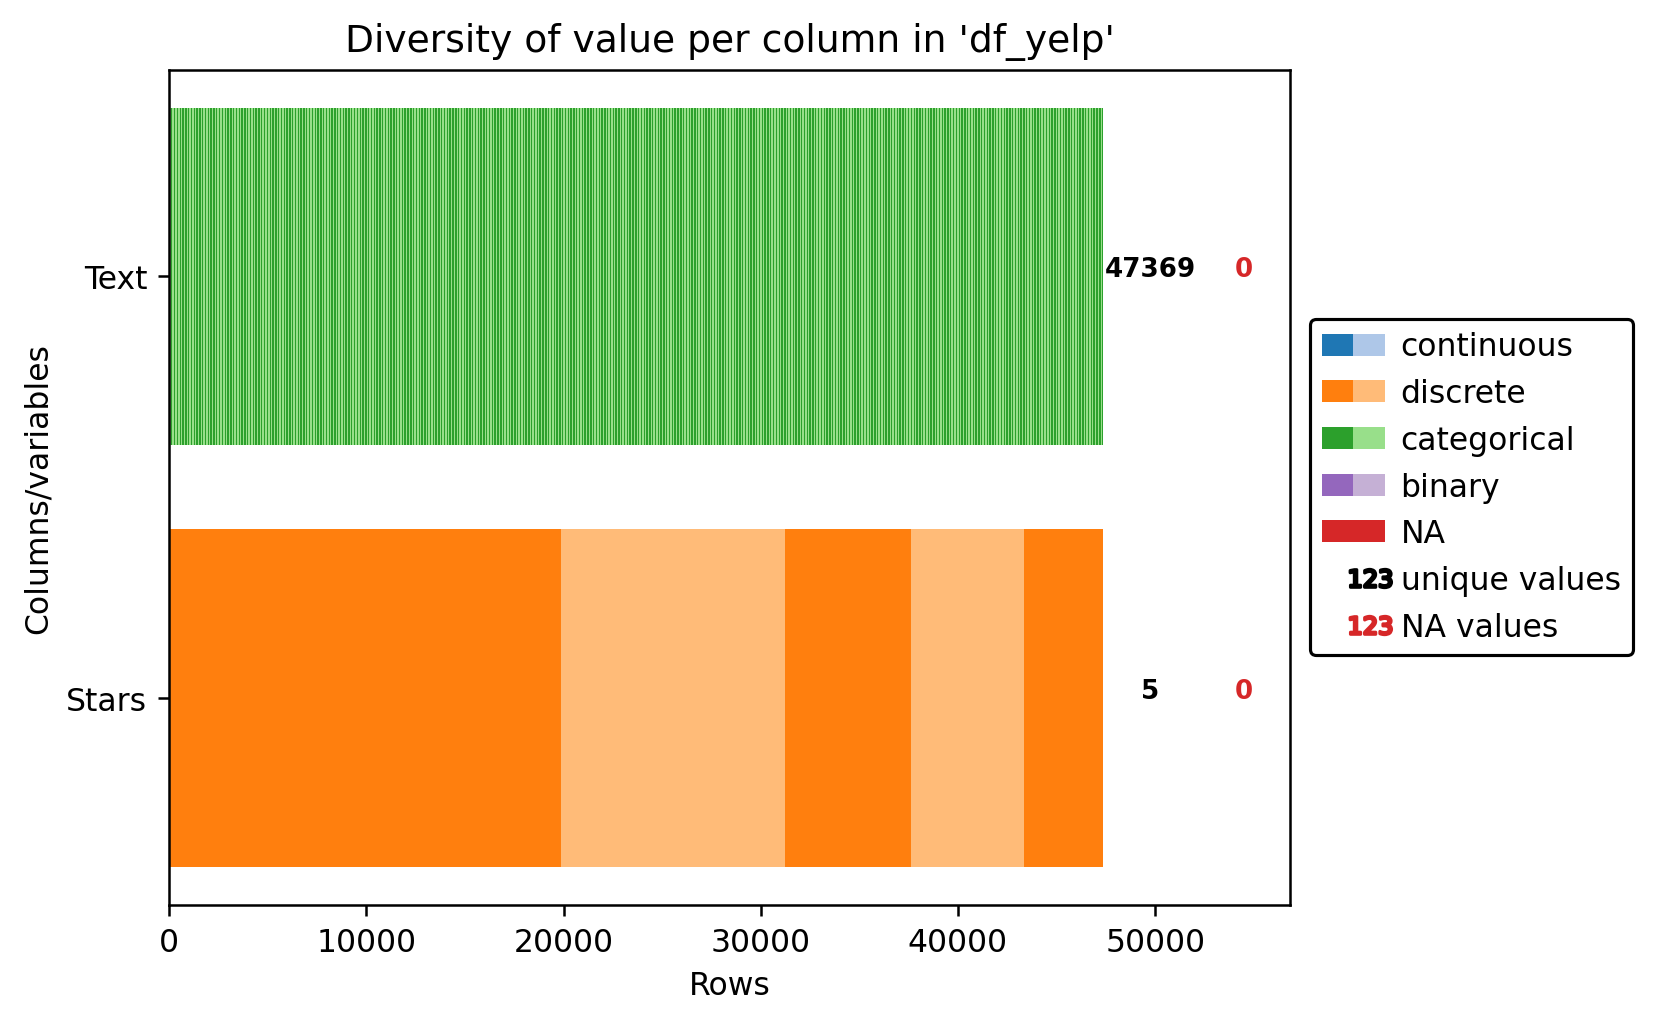

In [54]:
taa.explore_data(df_yelp, "df_yelp")

In [55]:
X = df_yelp["Text"].values
Y = df_yelp["Stars"].values

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.5, random_state=1)

PIPE_TEXT_ADA = fit_pipeline(PIPE_TEXT_ADA, xtrain, ytrain)
PIPE_TEXT_MLP = fit_pipeline(PIPE_TEXT_MLP, xtrain, ytrain)

#they are heavy
ypred_ADA = PIPE_TEXT_ADA.predict(xtest)
ypred_MLP = PIPE_TEXT_MLP.predict(xtest)

fit_pipeline: Saved to ../res/__cache_pickle__/fit_pipeline/3d3a76f6c9463c3dd7dba8a2b9516ef2350a8007.pkl


In [ ]:
taa.test_pipeline([PIPE_TEXT_ADA, PIPE_TEXT_MLP], xtest, ytest, score_params={'average': 'weighted'})

,method,accuracy,precision,recall,params
0,AdaBoostClassifier,0.548847,0.518083,0.548847,"(DecisionTreeClassifier(max_depth=1, random_st..."
1,MLPClassifier,0.538082,0.540150,0.538082,"MLPClassifier(hidden_layer_sizes=(100, 50), ra..."
